In [1]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import uuid
from faker import Faker
from scipy import stats
import seaborn as sns
from sklearn.utils import resample

Генерация синтетического датасета производилась ИИ, чтобы он создал структуры и часть инсайтов для работы

In [3]:
# Инициализация
np.random.seed(42)
random.seed(42)
fake = Faker(42)

n_samples = 600

# --- Справочники значений ---
transaction_types = ['income', 'expense', 'transfer', 'refund', 'investment']
departments = ['Sales', 'Marketing', 'R&D', 'HR', 'Finance', 'IT']
vendors = [fake.company() for _ in range(30)]
payment_methods = ['card', 'bank_transfer', 'cash', 'crypto']
categories = ['salary', 'software', 'hardware', 'services', 'travel', 'training', 'taxes', 'operational']
approvers = ['CEO', 'CFO', 'CTO', 'COO', 'HR_Manager']
project_codes = ['PRJ_' + str(i).zfill(3) for i in range(1, 21)]

# --- Дата ---
date_range = pd.date_range(start="2021-01-01", end="2024-06-01", freq='D')
dates = np.random.choice(date_range, size=n_samples)

# --- Сбор транзакций ---
data = {
    "Transaction_ID": [str(uuid.uuid4()) for _ in range(n_samples)],
    "Date": dates,
    "Transaction_Type": np.random.choice(transaction_types, size=n_samples, p=[0.25, 0.55, 0.08, 0.07, 0.05]),
    "Department": np.random.choice(departments, size=n_samples, p=[0.2, 0.2, 0.15, 0.15, 0.15, 0.15]),
    "Vendor": np.random.choice(vendors, size=n_samples),
    "Payment_Method": np.random.choice(payment_methods, size=n_samples, p=[0.3, 0.5, 0.1, 0.1]),
    "Category": np.random.choice(categories, size=n_samples),
    "Approved_by": np.random.choice(approvers, size=n_samples),
    "Recurring": np.random.choice([True, False], size=n_samples, p=[0.25, 0.75]),
    "Project_Code": np.random.choice(project_codes, size=n_samples)
}

df = pd.DataFrame(data)

# --- Генерация суммы ---
def generate_amount(ttype):
    if ttype == 'income':
        return round(np.random.normal(10000, 3000), 2)
    elif ttype == 'expense':
        return round(np.random.normal(-5000, 2000), 2)
    elif ttype == 'transfer':
        return round(np.random.normal(-1000, 500), 2)
    elif ttype == 'refund':
        return round(np.random.normal(500, 200), 2)
    elif ttype == 'investment':
        return round(np.random.normal(-15000, 5000), 2)
    return 0

df['Amount'] = df['Transaction_Type'].apply(generate_amount)

# --- Добавим фрод ---
df['Is_Fraudulent'] = False

# Кандидаты в фрод: подозрительные категории + crypto/cash + большие суммы
fraud_candidates = df[
    (df['Payment_Method'].isin(['crypto', 'cash'])) &
    (df['Amount'] < -3000) &
    (df['Category'].isin(['travel', 'training', 'hardware'])) &
    (df['Approved_by'].isin(['HR_Manager', 'COO']))
]

# Гарантируем минимум 35 фродов
n_frauds = max(35, int(n_samples * 0.07))
if len(fraud_candidates) >= n_frauds:
    fraud_indices = fraud_candidates.sample(n=n_frauds, random_state=42).index
else:
    # Если недостаточно по фильтру — заполним остальное случайными suspicious транзакциями
    additional_needed = n_frauds - len(fraud_candidates)
    other_candidates = df[
        (df['Amount'] < -4000) &
        (df['Payment_Method'].isin(['cash', 'crypto'])) &
        (~df.index.isin(fraud_candidates.index))
    ].sample(n=additional_needed, random_state=43, replace=False).index

    fraud_indices = fraud_candidates.index.union(other_candidates)

df.loc[fraud_indices, 'Is_Fraudulent'] = True

# --- Добавим аномального вендора (инсайт) ---
high_freq_vendor = random.choice(vendors)
df.loc[df.sample(frac=0.1, random_state=1).index, 'Vendor'] = high_freq_vendor

# --- Добавим немного пропусков (NaNs) ---
def insert_nans(df, column, frac=0.02):
    n_missing = int(len(df) * frac)
    missing_indices = np.random.choice(df.index, size=n_missing, replace=False)
    df.loc[missing_indices, column] = np.nan

# В какие колонки добавим NaNs
columns_with_nans = ['Vendor', 'Approved_by', 'Category', 'Project_Code']
for col in columns_with_nans:
    insert_nans(df, col, frac=0.02)

# --- Перемешаем строки для рандомизации ---
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# --- Сохраняем ---
df.to_csv("synthetic_financial_transactions.csv", index=False)

Названия колонок и их роль

Transaction_ID 	- Уникальный ID транзакции

Date -	Дата транзакции

Amount -	Сумма транзакции

Transaction_Type 	-	Тип транзакции: income, expense, transfer, refund, investment

Department 	Департамент: Sales, Marketing, R&D, HR, Finance, IT

Vendor 	-	Название поставщика / контрагента

Payment_Method 	 	Способ оплаты: card, bank_transfer, cash, crypto

Category 	-	Категория: salary, software, hardware, services, travel, training, taxes, operational

Approved_by  -	Кто одобрил: CEO, CFO, CTO, COO, HR_Manager

Recurring - 	Регулярная транзакция или нет

Project_Code  -	Код проекта, куда относится транзакция

Is_Fraudulent (target) - Метка: подозрительная операция или нет

In [4]:
data = pd.read_csv('synthetic_financial_transactions.csv', dayfirst=True)
data.sample(7)

,Transaction_ID,Date,Transaction_Type,Department,Vendor,Payment_Method,Category,Approved_by,Recurring,Project_Code,Amount,Is_Fraudulent
211,092d5d33-f7de-4150-99b7-b5fe0ace7ced,2022-04-01,income,Sales,Jackson LLC,card,taxes,CFO,False,PRJ_019,9823.71,False
246,5002d775-98f1-478e-b9f6-5d88b37dc522,2024-01-03,expense,Marketing,"Martinez, Smith and Harvey",bank_transfer,salary,CEO,False,PRJ_003,-8265.76,False
423,4d0e1c30-4b1e-482d-a6aa-58807d2c1942,2023-05-21,income,Sales,Hernandez LLC,crypto,training,HR_Manager,True,PRJ_016,9613.30,False
511,85b6146b-185f-49f0-9736-dabf5d50301e,2024-01-28,income,HR,"Jones, Matthews and Morrow",card,operational,CFO,True,PRJ_007,8858.78,False
135,f5fa5e10-5288-4b9d-9464-b48db6cb2896,2024-03-17,expense,Finance,Braun and Sons,card,taxes,CTO,False,PRJ_003,-7818.21,False
226,69a0c593-dd5d-45eb-8176-c88ebd4a0596,2021-11-17,expense,Sales,Chandler-Hicks,bank_transfer,taxes,COO,True,PRJ_020,-7122.59,False
116,c6d1a1e1-f861-4a13-bd41-b1ec93bd40f6,2021-11-01,expense,Finance,"Alexander, Rogers and Glass",card,travel,HR_Manager,True,PRJ_007,-3763.78,False


In [5]:
data.shape

(600, 12)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction_ID    600 non-null    object 
 1   Date              600 non-null    object 
 2   Transaction_Type  600 non-null    object 
 3   Department        600 non-null    object 
 4   Vendor            588 non-null    object 
 5   Payment_Method    600 non-null    object 
 6   Category          588 non-null    object 
 7   Approved_by       588 non-null    object 
 8   Recurring         600 non-null    bool   
 9   Project_Code      588 non-null    object 
 10  Amount            600 non-null    float64
 11  Is_Fraudulent     600 non-null    bool   
dtypes: bool(2), float64(1), object(9)
memory usage: 48.2+ KB


In [7]:
data['Date'] = pd.to_datetime(data['Date'])
data

,Transaction_ID,Date,Transaction_Type,Department,Vendor,Payment_Method,Category,Approved_by,Recurring,Project_Code,Amount,Is_Fraudulent
0,3bb6b133-316f-44ec-8c94-05fca51e9456,2022-11-15,expense,R&D,"Montgomery, Nelson and Bailey",card,training,NaN,False,PRJ_016,-4337.03,False
1,08c8518b-9682-4244-a362-06e4c3de0189,2022-03-18,investment,IT,Hernandez LLC,card,salary,CEO,True,PRJ_005,-12397.23,False
2,d57bf69a-3bee-4767-9892-3500eee39db3,2021-05-14,expense,HR,"Alexander, Rogers and Glass",bank_transfer,software,CTO,False,PRJ_008,-5348.30,False
3,95d55ce2-e45c-4772-a98c-538418f5dc94,2021-08-05,expense,Finance,"Fuller, Ferguson and Perez",cash,salary,HR_Manager,False,PRJ_019,-2891.18,False
4,ded7ed67-e1d7-4942-9d25-175a3bc4abf1,2023-06-03,income,R&D,Braun and Sons,card,operational,CEO,False,PRJ_005,8854.20,False
...,...,...,...,...,...,...,...,...,...,...,...,...
595,0e4002bf-2c79-4d0b-ae97-8ec0fd0eec14,2021-10-23,expense,Sales,Martin-Graham,bank_transfer,salary,CEO,False,PRJ_010,-8385.36,False
596,d4a79ec9-026d-45f0-8a9a-ea791ebeaa34,2022-05-18,expense,Finance,Duffy LLC,bank_transfer,travel,HR_Manager,True,PRJ_020,-5754.68,False
597,8d773069-9f9c-48e0-9064-af6ca0f0a670,2022-10-21,income,HR,"Martinez, Morris and Lee",bank_transfer,training,CEO,False,PRJ_006,12371.14,False
598,c9e0f381-47f6-427a-ad22-8d6d46fd8992,2024-04-06,refund,IT,Braun and Sons,card,travel,CTO,False,PRJ_019,569.33,False


In [8]:
data.isna().sum()

,0
Transaction_ID,0
Date,0
Transaction_Type,0
Department,0
Vendor,12
Payment_Method,0
Category,12
Approved_by,12
Recurring,0
Project_Code,12


In [9]:
df = data.dropna()
df.isna().sum()

,0
Transaction_ID,0
Date,0
Transaction_Type,0
Department,0
Vendor,0
Payment_Method,0
Category,0
Approved_by,0
Recurring,0
Project_Code,0


In [10]:
df = df.rename(columns=lambda x: x.lower())

In [11]:
df.drop(columns='transaction_id', axis=0, inplace=True)

In [12]:
df.describe()

,date,amount
count,553,553.000000
mean,2022-10-30 21:39:23.110307328,-1336.481374
min,2021-01-02 00:00:00,-23361.250000
25%,2022-01-15 00:00:00,-5720.210000
50%,2022-11-22 00:00:00,-3449.150000
75%,2023-09-20 00:00:00,569.330000
max,2024-05-31 00:00:00,17324.510000
std,NaN,7174.577807


In [13]:
df.columns

Index(['date', 'transaction_type', 'department', 'vendor', 'payment_method',
       'category', 'approved_by', 'recurring', 'project_code', 'amount',
       'is_fraudulent'],
      dtype='object')

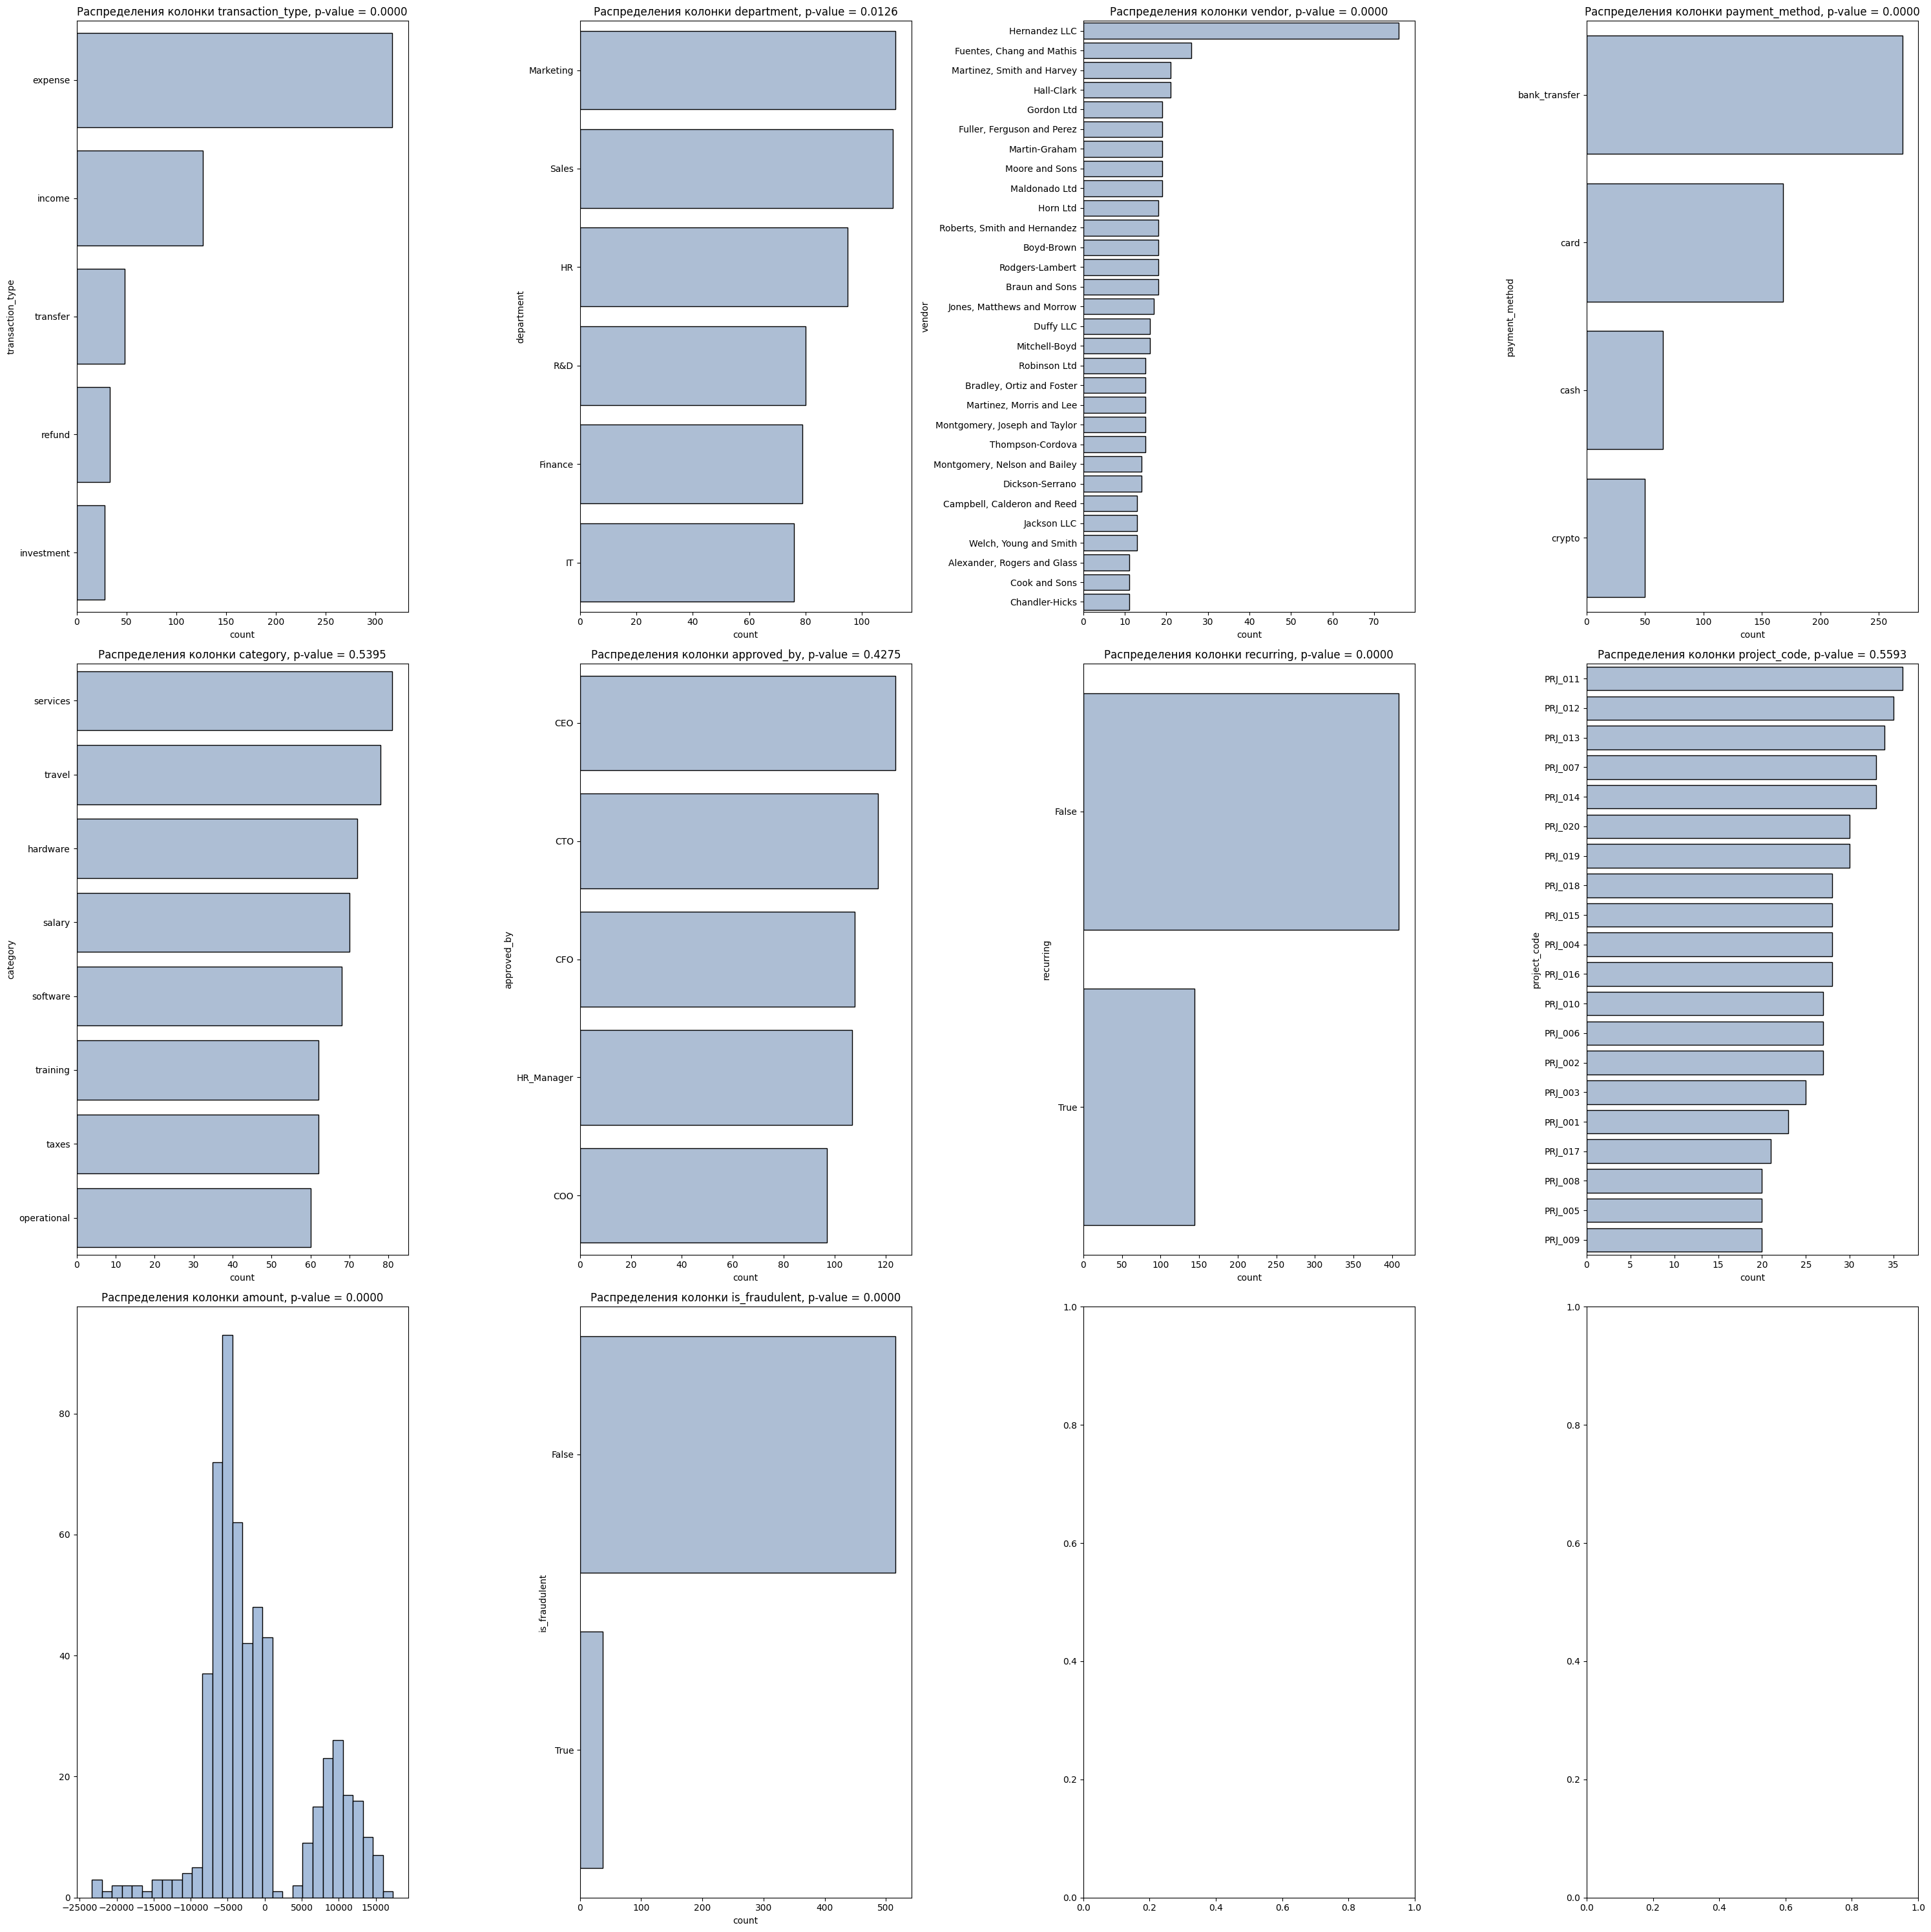

In [14]:
columns_distribution = ['transaction_type', 'department', 'vendor', 'payment_method',
       'category', 'approved_by', 'recurring', 'project_code', 'amount',
       'is_fraudulent']

fig, axes = plt.subplots(3, 4, figsize=(30, 30))
axes = axes.flatten()

for i, col in enumerate(columns_distribution[:len(axes)]):
  ax = axes[i]
  if df[col].dtype in ['int64', 'float64']:
    shap_stat, p_value = stats.shapiro(df[col])

    ax.hist(df[col], color='#a6bddb', bins=30, edgecolor='black')
    ax.set_title(f'Распределения колонки {col}, p-value = {p_value:.4f}')
  elif df[col].dtype in ['object', 'bool']:

    observed_counts = df[col].value_counts()
    expected_counts = [observed_counts.sum() / len(observed_counts)] * len(observed_counts)
    chi_stat, p_value = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)

    ax = sns.countplot(y=df[col].astype(str), ax=ax, color='#a6bddb', edgecolor='black', order=observed_counts.index)
    ax.set_title(f'Распределения колонки {col}, p-value = {p_value:.4f}')

plt.tight_layout()
plt.show()

Матрица графиков показывает, что колонка типа транзакций распределена не равномерна (p-value хи-квадрата = 0,0000) с чрезмерным преобладанием расходов. Аналогично и департаменты (p-value = 0.01), где маркетинг больше всего производит транзакций, а IT меньше всего. Большой перекос обнаружен и по продавцам с высокой монополией влияния "Weaver PLC" (p-value = 0.0000). Предпочтения методы оплаты также неравномерны с явным перекосом в сторону банковских платежей (p-value = 0.000). В свою очередь категории транзакций распределены достаточно равномерны (p-value = 0.54) о них в кампании не забывают. Что касается лиц, подтверждающих транзакции, то и здесь все, в целом, равномерно (p-value = 0.4275) все в той или иной "равной" статистической степени участвуют в подтверждении транзакций. Интересно, что по регулярности у нас наблюдается явный перевес "False" (p-value = 0.0000),  что говорит об относительных единоразовых транзакциях без долговременного вклада в общее дело. С учетом преобладания расходов над доходами - это может быть хорошей новостью. Что касается распределения транзакций по проектам, то и здесь, в целом, каждый проект в "равной" степени имеет операции (p-value = 0.56), компании о них не забывают, несмотря на высокое их количество. По суммам транзакции явно можно увидеть ненормальное распределение (p-value = 0.0000) в силу как положительных сумм (коих не так много), так и отрицательных (превалирование) в данных. Это говорит о больших издержках и требует внимания к себе. Последняя колонка с "Мошеннический платеж или нет" имеет преобладание метки "False" (p-value = 0.0000) что, в целом, и должно быть - ведь иначе организация юридически не должна была бы существовать


1. Как распределены транзакции по типам (transaction_type)?
2.  Какое общее соотношение доходов и расходов по сумме (amount)?
3. Какие департаменты совершают больше всего транзакций и на какие суммы?
4. Какое распределение способов оплаты (payment_method) по типам транзакций?
5. Какие категории (category) являются самыми затратными?
6.  Как распределены суммы (amount) в зависимости от одобряющего лица (approved_by)?
7.  Какие проекты (project_code) потребляют наибольшие бюджеты?
8.  Как меняется активность транзакций по месяцам и годам?
9. Есть ли сезонность в доходах и расходах?
10.  Какие признаки чаще встречаются в фродовых транзакциях (is_fraudulent=True)?
11. Какое распределение сумм у фродовых vs. нормальных транзакций?
12. Какие поставщики (vendor) чаще фигурируют во фродовых операциях?
13. Есть ли связь между фродом и регулярностью (recurring)?
14. Есть ли департаменты, которые чаще попадают в фрод?
15. Какие наиважные признаки у фродовых и нормальных транзакций?

1. Как распределены транзакции по типам (transaction_type)?

In [15]:
df['transaction_type'].value_counts()

,count
transaction_type,
expense,317
income,127
transfer,48
refund,33
investment,28


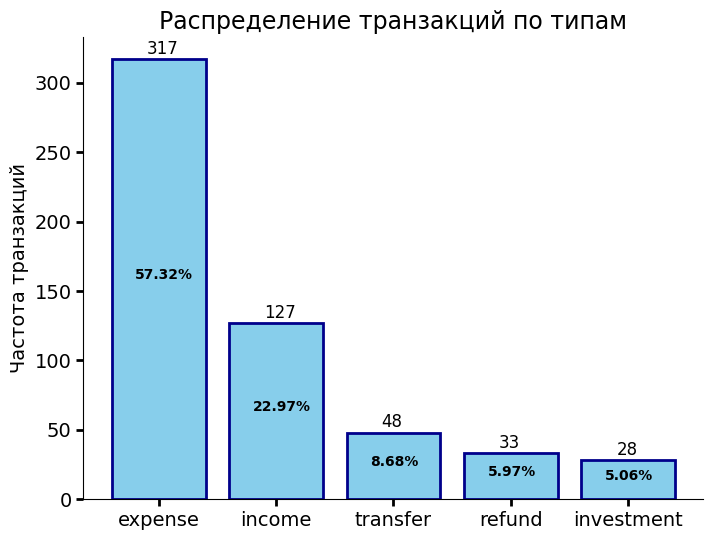

In [16]:
transactionCounts = df['transaction_type'].value_counts()
fraction = len(df['transaction_type'])

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(transactionCounts.index, transactionCounts.values, color='#87CEEB', edgecolor='#00008B', linewidth=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for bar in bars:
  x = bar.get_x() + bar.get_width()/2 - 0.1
  y = bar.get_height()

  ax.text(x, y+4, f'{y}', fontsize=12)
  ax.text(x-0.10, y/2, f'{y/fraction * 100:.2f}%', fontsize=10, fontweight='bold')


ax.tick_params(axis='both', which='major', direction='out', labelsize=14, length=5, width=2)
ax.set_ylabel('Частота транзакций', fontsize=14)
plt.title('Распределение транзакций по типам', fontsize=17)
plt.show()

Более 50% транзакций компаний являются расходы, в то время как доходов в явном виде (income) только 22,97%. Разрыв в 2.5 раза между доходами и расходами - является неудовлетворительным знаком для компании и может характеризовать отрицательный денежный поток

2. Какое общее соотношение доходов и расходов по сумме (amount)?

Доля суммы доходов в потоке = 44.46%, а доля суммы расходов = 55.54%


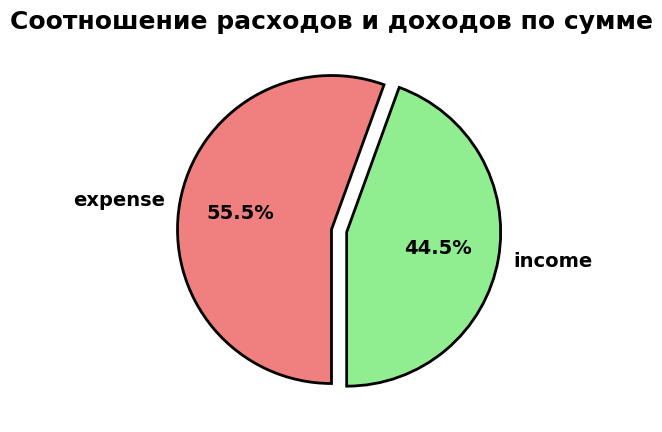

In [17]:
full_income = df[df['transaction_type'] == 'income']['amount'].sum()
full_expense = abs(df[df['transaction_type'] == 'expense']['amount'].sum())
full_amount = full_expense + full_income

plt.figure(figsize=(10, 5))
plt.pie(
    [full_income, full_expense], labels=['income', 'expense'], explode=[0.1, 0], startangle=270, colors=['#90EE90','#F08080'],
    textprops={'fontsize': 14, 'fontweight': 800}, autopct='%1.1f%%', wedgeprops={'edgecolor': 'black', 'linewidth': 2}
)
plt.title('Соотношение расходов и доходов по сумме', fontsize=18, fontweight=600)

print(f'Доля суммы доходов в потоке = {full_income/full_amount * 100:.2f}%, а доля суммы расходов = {full_expense/full_amount * 100:.2f}%')

Соотношение доходов и расходов подтверждают предыдущий вывод о преобладании расходов в общей части как по количеству транзакций, так и по их сумме, примерно 60/40. Это не прямо критичное значение - но для трехгодового развития фирмы - звоночек в сторону оптимизации этого направления

3. Какие департаменты совершают больше всего транзакций и на какие суммы?

In [18]:
import plotly.express as px

In [19]:
amount_transaction = df.copy()
amount_transaction['amount'] = abs(amount_transaction['amount'])

fig = px.histogram(amount_transaction, x='amount', nbins=25, color='department', hover_data=amount_transaction.columns, facet_col='department',
                   histfunc='count', text_auto=True)

fig.update_traces(marker_line_color='black', marker_line_width=1.5)
fig.update_yaxes(range=[0, 20])
fig.update_layout(title={
    'text':'Распределение транзакций между отделами компании',
    'xanchor': 'center',
    'yanchor': 'top',
    'y':0.99,
    'x':0.5,
    'font':{'size': 20}
})
fig.show()

In [20]:
pd.pivot_table(data=amount_transaction, values='amount', index='department', aggfunc=['count', 'mean', 'max', 'min'])

,count,mean,max,min
,amount,amount,amount,amount
department,,,,
Finance,79,5867.523165,15531.70,96.74
HR,95,5993.711368,22540.94,33.77
IT,76,5011.354342,14976.99,3.29
Marketing,112,6646.205089,23361.25,437.60
R&D,80,5860.686125,15092.30,130.52
Sales,111,6276.952252,18381.21,30.06


Департаменты с наибольшей частотой транзакций - это маркетинговый и продажный. Однако, наибольший удельный вес по объему вносит именно департамент маркетинга, объем операций которого выше всех остальных департаментов.

Отдельно следует обратить внимание на HR-отдел, который несмотря на меньшее количество операций - имеет транзакцию по максимальному объему денежных средств, близкую к маркетинговому департаменту. Это интересно, т.к. средний объем операций куда меньше

4. Какое распределение способов оплаты (payment_method) по типам транзакций?

In [21]:
crosspayment = pd.crosstab(df['transaction_type'], df['payment_method'])
crosspayment

payment_method,bank_transfer,card,cash,crypto
transaction_type,,,,
expense,161,95,37,24
income,59,41,16,11
investment,15,7,4,2
refund,13,11,4,5
transfer,22,14,4,8


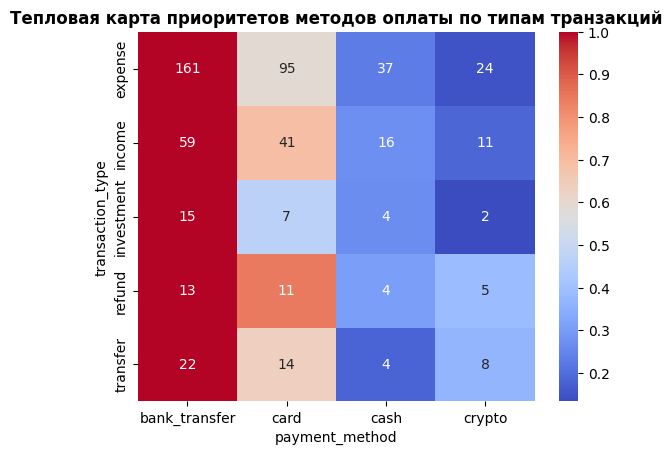

In [22]:
import seaborn as sns
normalized_data = crosspayment.div(crosspayment.max(axis=1), axis=0)

sns.heatmap(normalized_data, annot=crosspayment, fmt='.0f', cmap='coolwarm')
plt.title('Тепловая карта приоритетов методов оплаты по типам транзакций', fontweight=700)
plt.show()

Бесцеремонным лидером методов оплаты является банковский период, транзакции по которому осуществляелись больше всего во всех типах операций. В целом, наблюдается устойчивая частотность "bank_transfer > card > cash > crypto", что нормально. Интересно, что примерно 17% операций переводов осуществлялись через крипту. Возможно это из-за скорости или трансграничного характера подобных операций

5. Какие категории (category) являются самыми затратными?

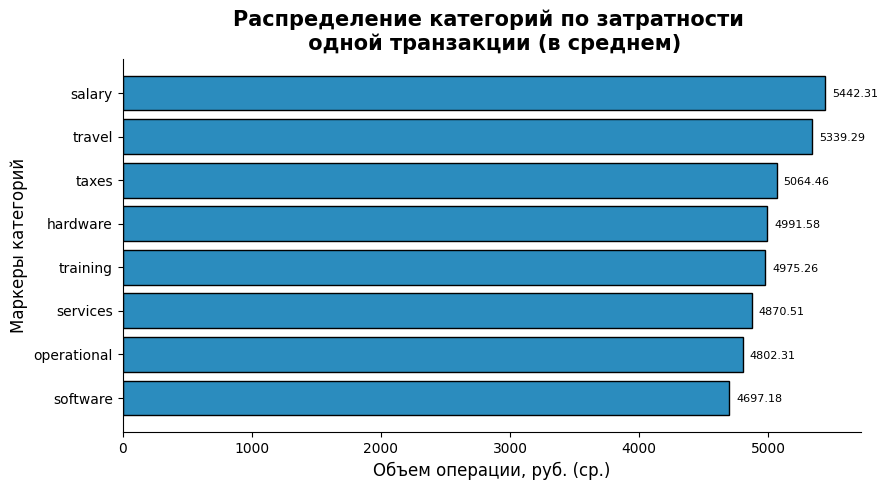

В среднем, разница между самой затратной и незатратной категорией равняется 745.14


In [23]:
# Затратные в нашем понимании будут те, где transaction_type = expense как самое очевидное и ясное из условий

exp_cat = abs(df[df['transaction_type'] == 'expense'].groupby('category')['amount'].mean()).sort_values(ascending=True)

fig, axes = plt.subplots(figsize=(9, 5))
bars = axes.barh(exp_cat.index, exp_cat.values, edgecolor='black', color='#2b8cbe')
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

for bar in bars:
  x = bar.get_width()
  y = bar.get_y() + bar.get_height()/2 - 0.1

  axes.text(x+(exp_cat.max() * 0.01), y, f'{x:.2f}', fontsize=8)

plt.ylabel('Маркеры категорий', fontsize=12)
plt.xlabel('Объем операции, руб. (ср.)', fontsize=12)
plt.title('Распределение категорий по затратности \n одной транзакции (в среднем)', fontsize=15, fontweight=700)
plt.tight_layout()
plt.show()

first_diff_last = abs(exp_cat.iloc[-1] - exp_cat.iloc[0])
print(f'В среднем, разница между самой затратной и незатратной категорией равняется {first_diff_last:.2f}')

Из данного анализа видно, что наибольшая затратная часть в категории "заработной платы", наименее затратная часть - "ПО" (возможно в силу скидок на лицензии или иные моменты). В целом, в данном распределении ничего такого необычного нет

6. Как распределены суммы (amount) в зависимости от одобряющего лица (approved_by)?

In [24]:
pd.pivot_table(data=df, values='amount', index='approved_by', aggfunc=['count', 'mean', 'min', 'max'])

,count,mean,min,max
,amount,amount,amount,amount
approved_by,,,,
CEO,124,-1090.446774,-12448.86,15021.70
CFO,108,-855.168796,-22540.94,17324.51
COO,97,-1115.890206,-20937.33,15053.05
CTO,117,-2681.578718,-23361.25,15053.74
HR_Manager,107,-836.584206,-18381.21,15419.60


In [25]:
fig = px.histogram(df, x='amount', nbins=22, color='approved_by', hover_data=amount_transaction.columns, facet_col='approved_by',
                   histfunc='count', text_auto=True, animation_frame='category')
x_min = -20000
x_max = 20000
y_max = 10

fig.update_traces(marker_line_color='black', marker_line_width=1.5)
fig.update_yaxes(range=[0, 10])
fig.update_layout(title={
    'text':'Распределение сумм транзакций на категории в зависимости от одобрящего лица',
    'xanchor': 'center',
    'yanchor': 'top',
    'y':0.99,
    'x':0.5,
    'font':{'size': 20}},
    xaxis=dict(range=[x_min, x_max]),
    yaxis=dict(range=[0, y_max]),
    )
for i in fig.layout:
    if i.startswith('xaxis'):
        fig.layout[i].range = [x_min, x_max]
    elif i.startswith('yaxis'):
        fig.layout[i].range = [0, y_max]

bins = np.linspace(x_min, x_max, 21)
fig.update_traces(xbins=dict(start=x_min, end=x_max, size=(x_max-x_min)/20))
fig.show()

В среднем, от каждого одобряющего руководителя транзакции имели отрицательные суммы. Несмотря на это, в среднем, меньшие суммы встречаются именно от HR. В тоже время большие суммы встречаются у CTO

Вопрос 7. Какие проекты (project_code) потребляют наибольшие бюджеты?

In [26]:
# потребляют - значит имеют "расходы", т.е. expenses
filter_expense = df.loc[df['transaction_type'] == 'expense'].copy()
filter_expense['amount'] = abs(filter_expense['amount'])

expense_amount_project = pd.pivot_table(
    data=filter_expense,
    values='amount',
    index='project_code',
    aggfunc=['count', 'sum', 'mean', 'min', 'max']).reset_index()
expense_amount_project.columns = ['project_code'] + [col[0] for col in expense_amount_project.columns if col[0] != 'project_code']
expense_amount_project = expense_amount_project.sort_values(by='sum', ascending=False)
expense_amount_project

,project_code,count,sum,mean,min,max
10,PRJ_011,26,139273.66,5356.679231,2670.83,7952.13
12,PRJ_013,24,114182.30,4757.595833,1380.97,7313.96
13,PRJ_014,20,99762.93,4988.146500,1191.13,7309.73
11,PRJ_012,18,93905.77,5216.987222,1508.26,10176.83
5,PRJ_006,16,88372.88,5523.305000,171.57,8339.74
19,PRJ_020,18,88249.77,4902.765000,758.86,8126.18
3,PRJ_004,16,86116.35,5382.271875,3006.95,10799.79
15,PRJ_016,17,83308.01,4900.471176,30.06,8161.50
9,PRJ_010,17,80141.24,4714.190588,2108.27,8669.62
6,PRJ_007,18,78984.10,4388.005556,3.29,8191.27


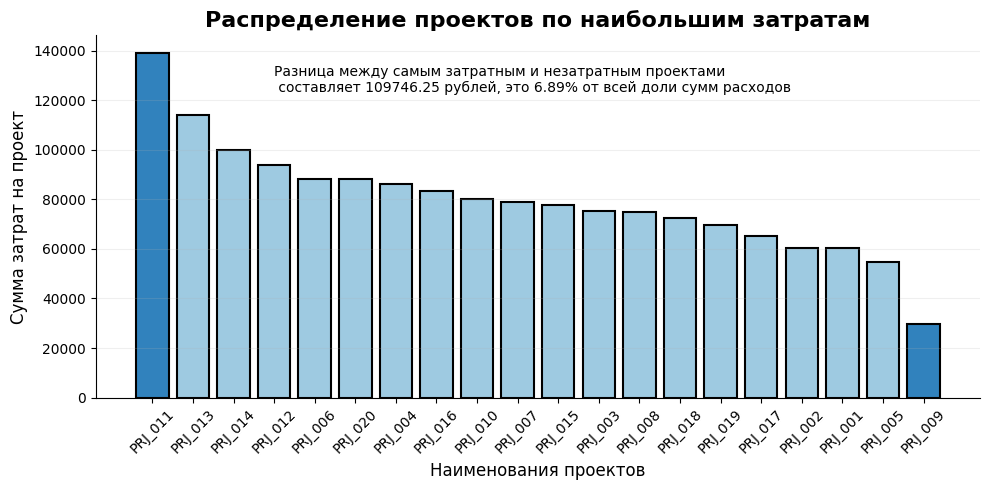

Разница между самым затратным и незатратным проектами составляет 109746.25 рублей!


In [27]:
colors_project = ['#9ecae1'] * len(expense_amount_project)
colors_project[0] = '#3182bd'
colors_project[-1] = '#3182bd'

dif = expense_amount_project['sum'].max() - expense_amount_project['sum'].min()
fraction_biggest = dif/expense_amount_project['sum'].sum() * 100

fig, axes = plt.subplots(figsize=(10, 5))
plt.bar(expense_amount_project['project_code'], height=expense_amount_project['sum'],
        color = colors_project, edgecolor='black', linewidth=1.5)
plt.xticks(rotation=45)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)


plt.annotate(f'Разница между самым затратным и незатратным проектами \n составляет {dif} рублей, это {fraction_biggest:.2f}% от всей доли сумм расходов',
             xy=(3, 2223),  xytext =(3, expense_amount_project['sum'].median() + 45000))
plt.title('Распределение проектов по наибольшим затратам', fontsize=16, fontweight=700)
plt.ylabel('Сумма затрат на проект', fontsize=12, fontweight=300)
plt.xlabel('Наименования проектов', fontsize=12, fontweight=300)
plt.grid(alpha=0.2, axis='y')

plt.tight_layout()
plt.show()
print(f'Разница между самым затратным и незатратным проектами составляет {dif} рублей!')

Вопрос 8. Как меняется активность транзакций по месяцам и годам?

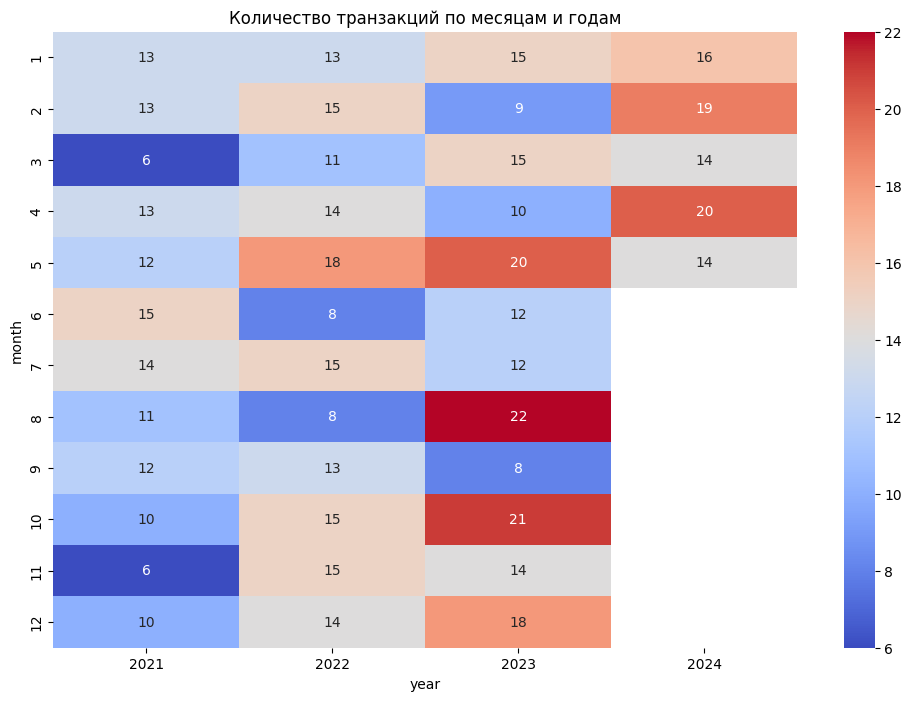

In [28]:
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day

df['amount'] = df['amount'].abs()

transaction_counts = df.groupby(['year', 'month']).size().reset_index(name='count')
pivot_counts = transaction_counts.pivot(index='month', columns='year', values='count')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_counts, annot=True, cmap='coolwarm', fmt='g')
plt.title('Количество транзакций по месяцам и годам')
plt.show()

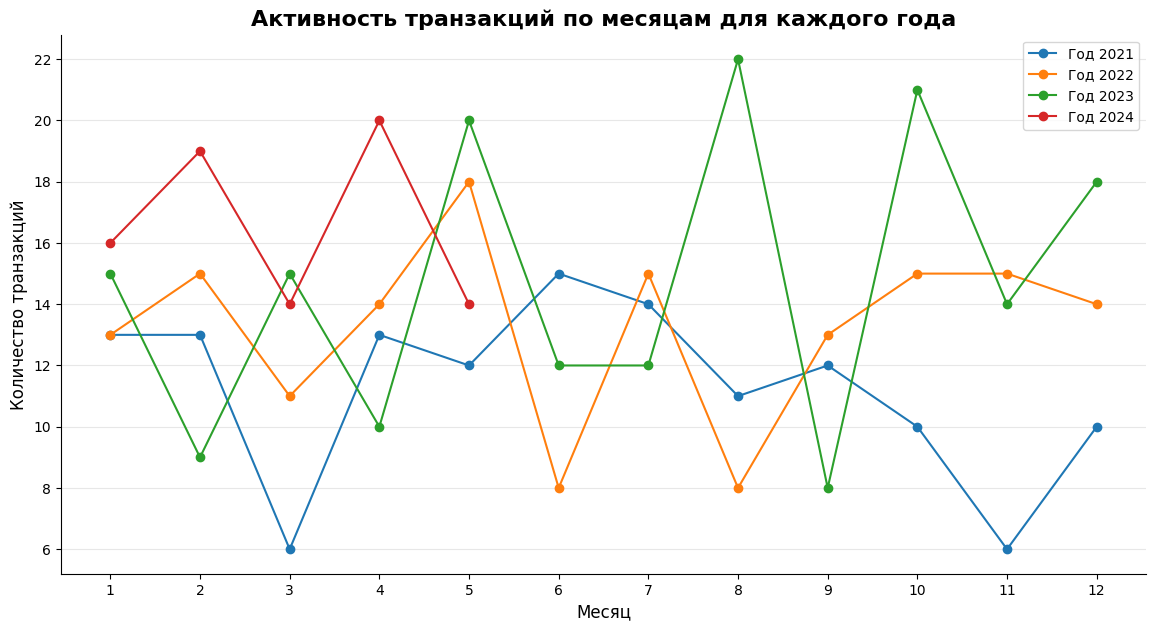

In [29]:
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(figsize=(14, 7))
for year in sorted(df['year'].unique()):
    year_data = transaction_counts[transaction_counts['year'] == year]
    plt.plot(year_data['month'], year_data['count'], marker='o', label=f'Год {year}')

plt.xlabel('Месяц', fontsize=12, fontweight=300)
plt.ylabel('Количество транзакций', fontsize=12, fontweight=300)
plt.title('Активность транзакций по месяцам для каждого года', fontsize=16, fontweight=700)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

axes.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.xticks(range(1, 13))
plt.grid(alpha=0.3, axis='y')
plt.legend()
plt.show()

In [30]:
!pip install pymannkendall
import pymannkendall as mk

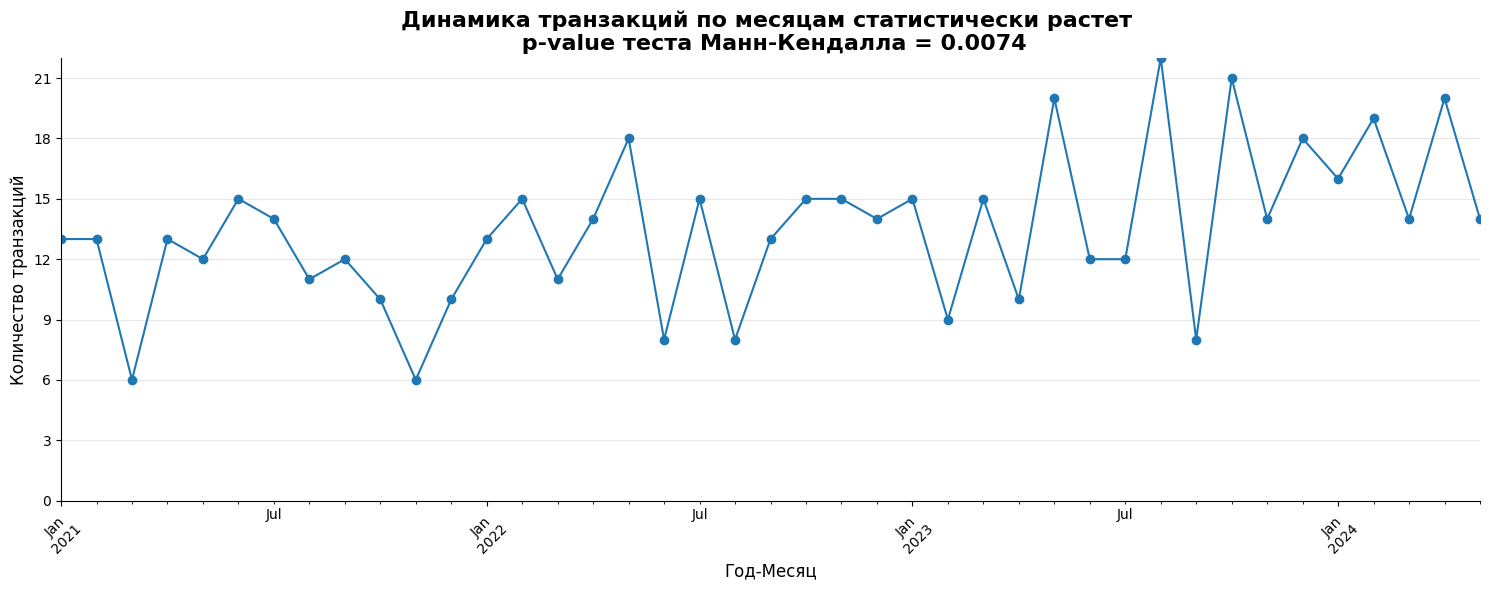

Статистика теста Манн-Кендалла 
 Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(0.0073507900623748235), z=np.float64(2.6805198683194007), Tau=np.float64(0.29024390243902437), s=np.float64(238.0), var_s=np.float64(7817.333333333333), slope=np.float64(0.12701612903225806), intercept=np.float64(11.45967741935484))


In [31]:
df['yearmonth'] = pd.to_datetime(df['date']).dt.to_period('M')
monthly_counts = df.groupby('yearmonth').size()

mk_count_transaction = mk.original_test(monthly_counts)

fig, axes = plt.subplots(figsize=(15, 6))
monthly_counts.plot(kind='line', marker='o')
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

plt.title(f'Динамика транзакций по месяцам статистически растет \n p-value теста Манн-Кендалла = {mk_count_transaction[2]:.4f}', fontsize=16, fontweight=700)
plt.xlabel('Год-Месяц', fontsize=12, fontweight=300)
plt.ylabel('Количество транзакций', fontsize=12, fontweight=300)

axes.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.ylim(0, monthly_counts.max())
plt.grid(alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(f'Статистика теста Манн-Кендалла \n {mk_count_transaction}')

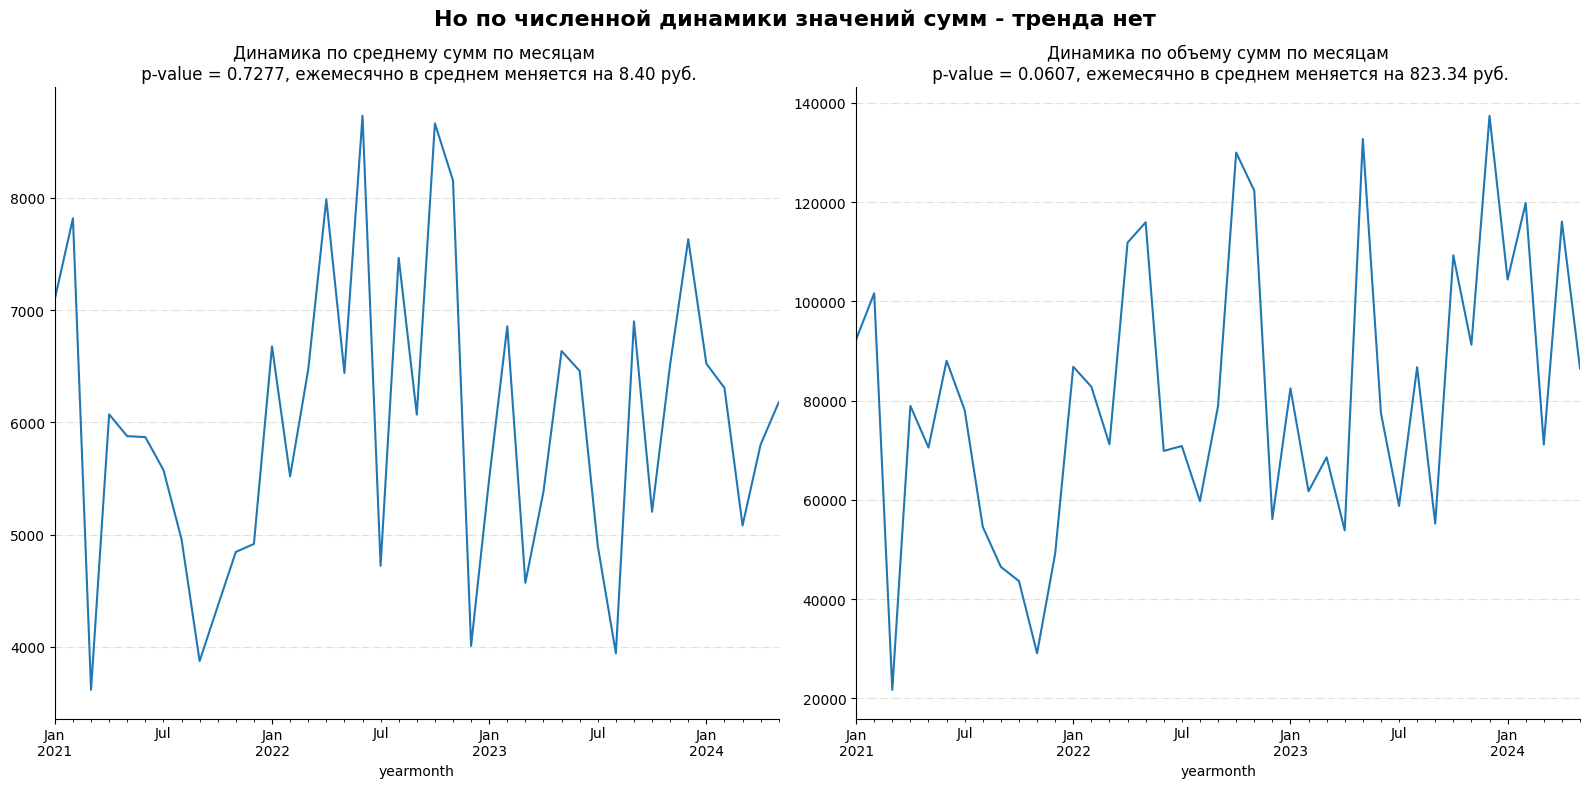

Статистика теста Манн-Кендалла по среднему сумм 
 Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.7276974359007813), z=np.float64(0.34819008178434047), Tau=np.float64(0.03902439024390244), s=np.float64(32.0), var_s=7926.666666666667, slope=np.float64(8.40349395313681), intercept=np.float64(5901.411659398801))
Статистика теста Манн-Кендалла по объему сумм транзакций 
 Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.06069186057338816), z=np.float64(1.8757336663866082), Tau=np.float64(0.2048780487804878), s=np.float64(168.0), var_s=7926.666666666667, slope=np.float64(823.3404215686277), intercept=np.float64(62436.45156862744))


In [32]:
mean_amount_yearmonth = df.groupby('yearmonth')['amount'].mean()
sum_amount_yearmonth = df.groupby('yearmonth')['amount'].sum()

mk_mean_amount_yearmonth = mk.original_test(mean_amount_yearmonth)
mk_sum_amount_yearmonth = mk.original_test(sum_amount_yearmonth)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Но по численной динамики значений сумм - тренда нет', fontsize=16, fontweight=700)

axes[0] = mean_amount_yearmonth.plot(ax=axes[0])
axes[0].set_title(f'Динамика по среднему сумм по месяцам \n p-value = {mk_mean_amount_yearmonth[2]:.4f}, ежемесячно в среднем меняется на {mk_mean_amount_yearmonth[7]:.2f} руб.')
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].grid(alpha=0.4, axis='y', linestyle='-.')

axes[1] = sum_amount_yearmonth.plot(ax=axes[1])
axes[1].set_title(f'Динамика по объему сумм по месяцам\n p-value = {mk_sum_amount_yearmonth[2]:.4f}, ежемесячно в среднем меняется на {mk_sum_amount_yearmonth[7]:.2f} руб.')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].grid(alpha=0.4, axis='y', linestyle='-.')

plt.tight_layout()
plt.show()

print(f'Статистика теста Манн-Кендалла по среднему сумм \n {mk_mean_amount_yearmonth}')
print(f'Статистика теста Манн-Кендалла по объему сумм транзакций \n {mk_sum_amount_yearmonth}')

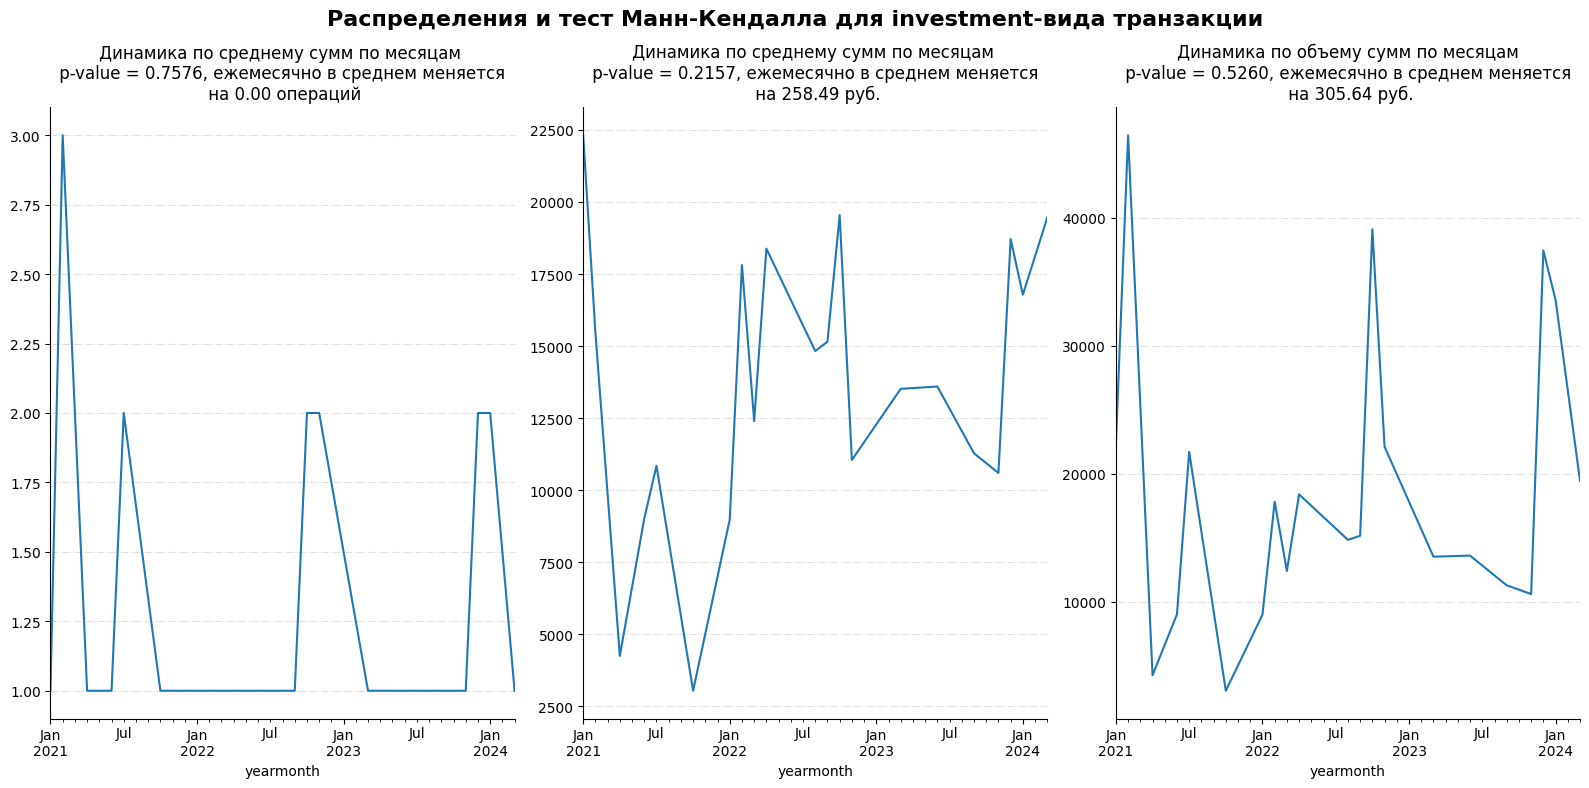

Статистика теста Манн-Кендалла по транзакциям типа investment 
по количеству 
 Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.75756247304732), z=np.float64(0.3086832677705237), Tau=np.float64(0.04285714285714286), s=np.float64(9.0), var_s=np.float64(671.6666666666666), slope=np.float64(0.0), intercept=np.float64(1.0)) 
по среднему сумм 
 Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.21568869559132287), z=np.float64(1.2380738054414868), Tau=np.float64(0.2), s=np.float64(42.0), var_s=1096.6666666666667, slope=np.float64(258.48759090909095), intercept=np.float64(11012.46409090909)) 
по объему сумм 
 Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.5259924856094209), z=np.float64(0.6341353637627127), Tau=np.float64(0.10476190476190476), s=np.float64(22.0), var_s=1096.6666666666667, slope=np.float64(305.6400000000003), intercept=np.float64(12095.609999999997))


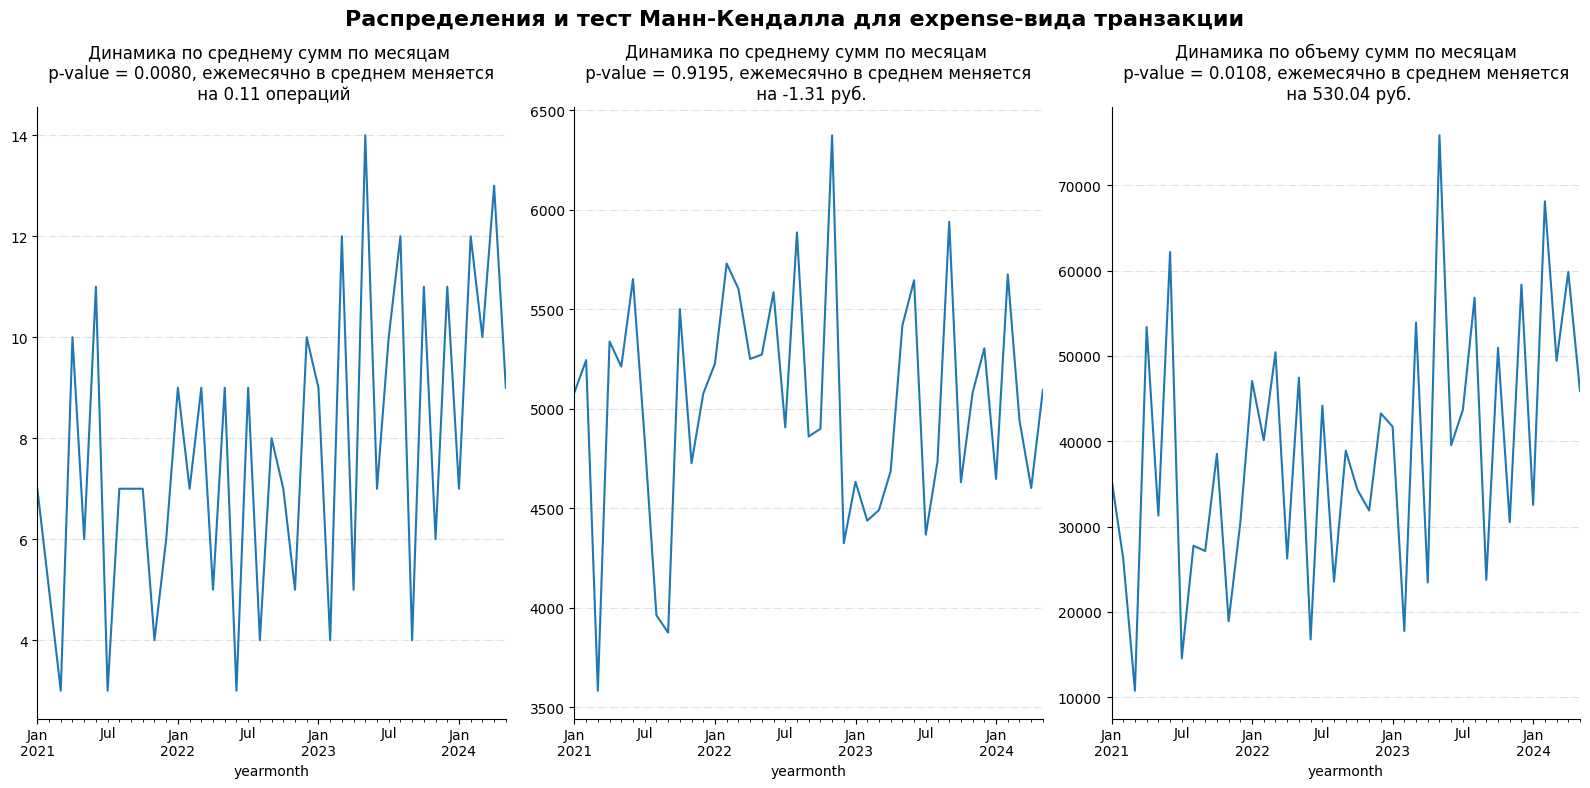

Статистика теста Манн-Кендалла по транзакциям типа expense 
по количеству 
 Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(0.008029392659407941), z=np.float64(2.65083133916965), Tau=np.float64(0.2865853658536585), s=np.float64(235.0), var_s=np.float64(7792.333333333333), slope=np.float64(0.11269841269841269), intercept=np.float64(4.746031746031746)) 
по среднему сумм 
 Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.919481045938793), z=np.float64(-0.10108744309867948), Tau=np.float64(-0.012195121951219513), s=np.float64(-10.0), var_s=7926.666666666667, slope=np.float64(-1.3114406565656611), intercept=np.float64(5108.547146464647)) 
по объему сумм 
 Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(0.010783112709874754), z=np.float64(2.549649953711138), Tau=np.float64(0.2780487804878049), s=np.float64(228.0), var_s=7926.666666666667, slope=np.float64(530.0400101419879), intercept=np.float64(28289.17979716024))


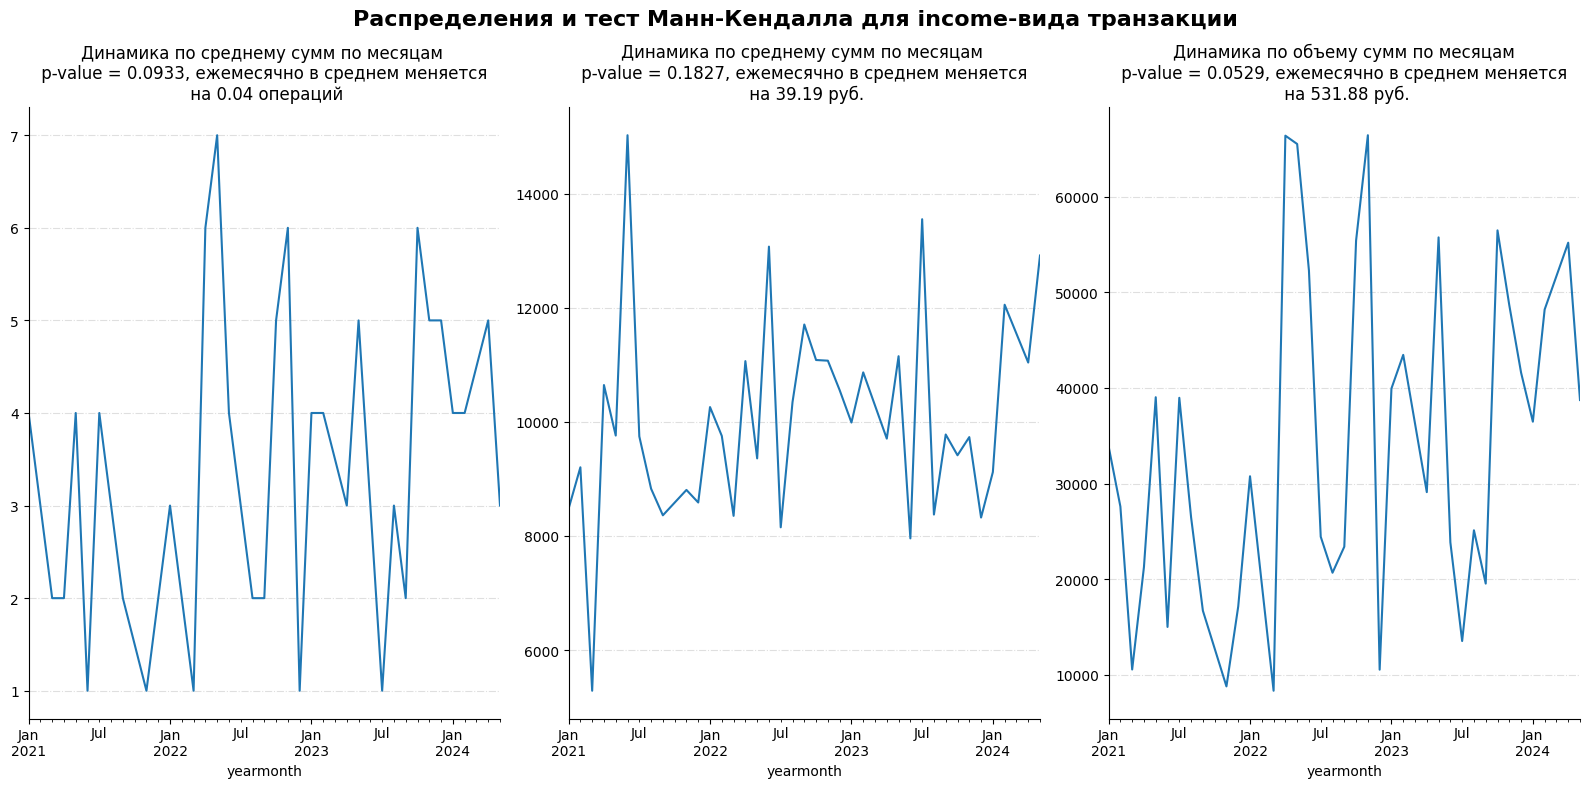

Статистика теста Манн-Кендалла по транзакциям типа income 
по количеству 
 Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.0933258944084483), z=np.float64(1.678108629489242), Tau=np.float64(0.18776671408250356), s=np.float64(132.0), var_s=np.float64(6094.0), slope=np.float64(0.03571428571428571), intercept=np.float64(2.3392857142857144)) 
по среднему сумм 
 Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.18265591265350256), z=np.float64(1.3326219059816617), Tau=np.float64(0.15220483641536273), s=np.float64(107.0), var_s=6327.0, slope=np.float64(39.18885937499999), intercept=np.float64(9030.3973515625)) 
по объему сумм 
 Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.05285871980753898), z=np.float64(1.9360733351054331), Tau=np.float64(0.22048364153627312), s=np.float64(155.0), var_s=6327.0, slope=np.float64(531.8820000000001), intercept=np.float64(20103.388))


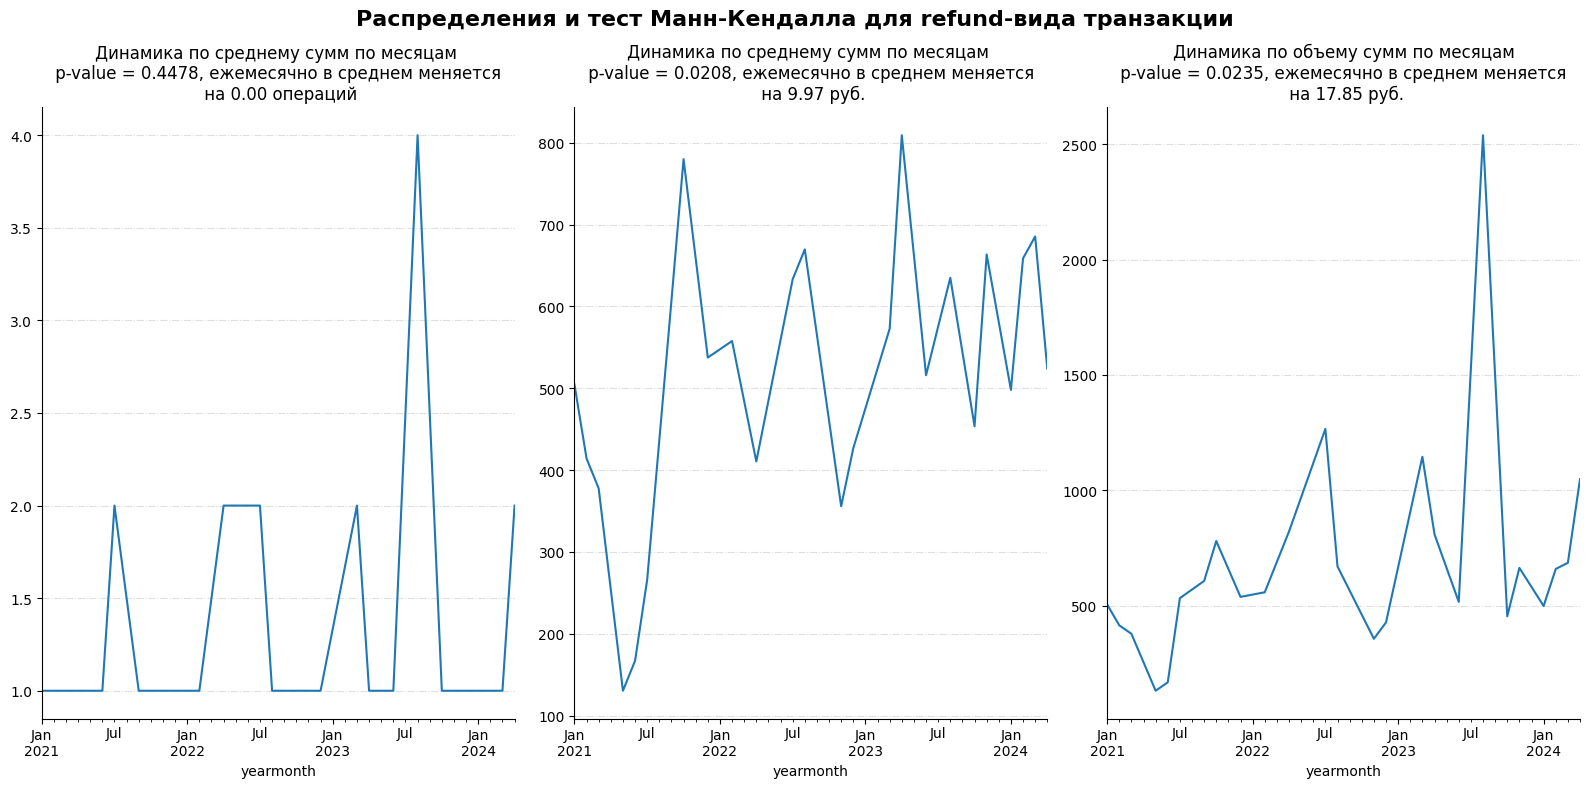

Статистика теста Манн-Кендалла по транзакциям типа refund 
по количеству 
 Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.4478087930611496), z=np.float64(0.759073161178381), Tau=np.float64(0.08333333333333333), s=np.float64(25.0), var_s=np.float64(999.6666666666666), slope=np.float64(0.0), intercept=np.float64(1.0)) 
по среднему сумм 
 Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(0.020769866768182377), z=np.float64(2.3121418641597233), Tau=np.float64(0.3333333333333333), s=np.float64(100.0), var_s=1833.3333333333333, slope=np.float64(9.970416666666669), intercept=np.float64(404.41)) 
по объему сумм 
 Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(0.023486186933639575), z=np.float64(2.265431927510032), Tau=np.float64(0.32666666666666666), s=np.float64(98.0), var_s=1833.3333333333333, slope=np.float64(17.849375), intercept=np.float64(343.48749999999995))


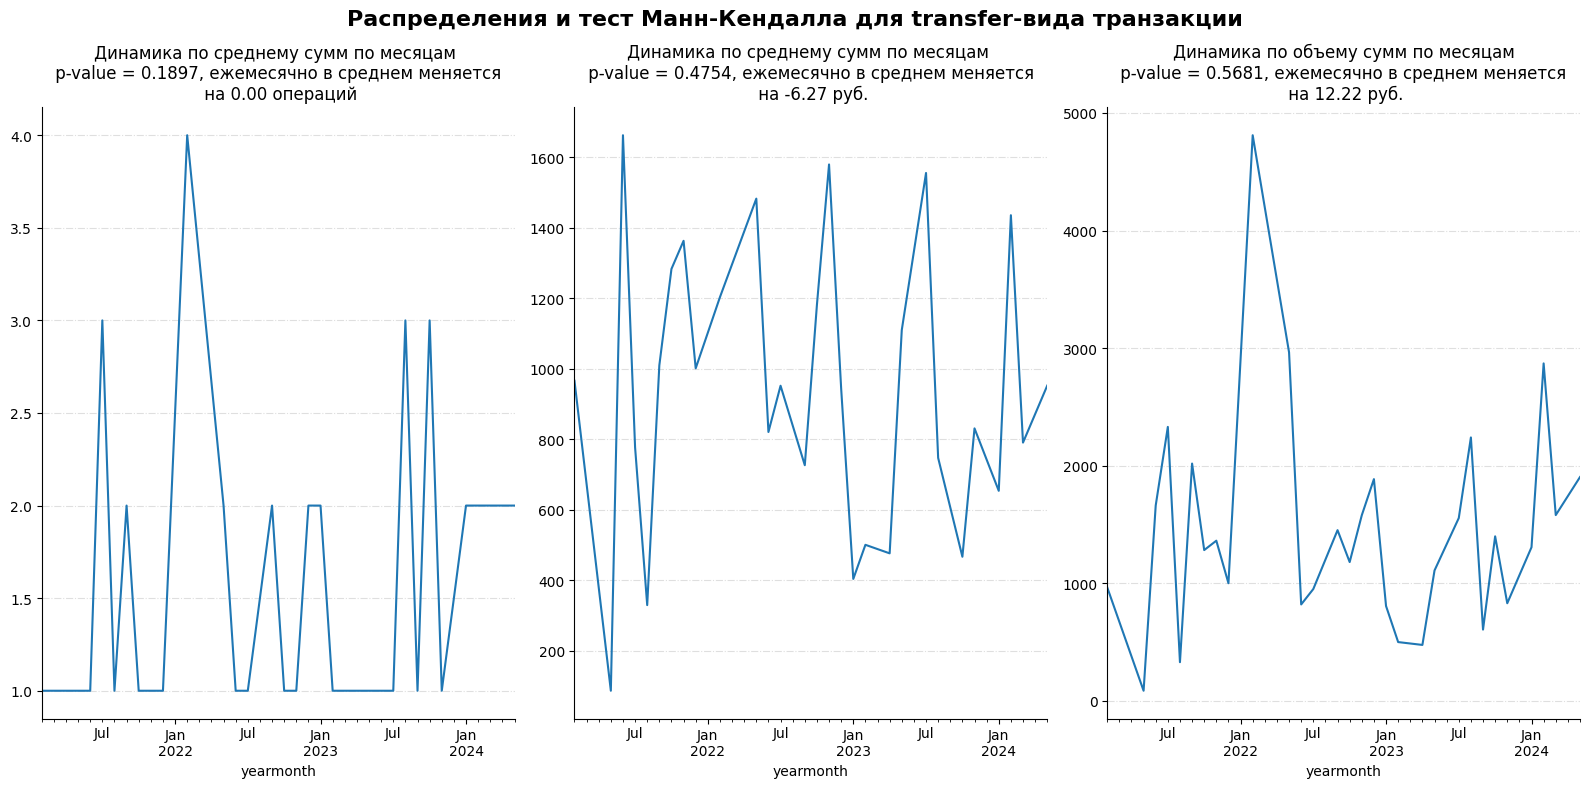

Статистика теста Манн-Кендалла по транзакциям типа transfer 
по количеству 
 Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.18971749872721588), z=np.float64(1.3114152815586537), Tau=np.float64(0.15172413793103448), s=np.float64(66.0), var_s=np.float64(2456.6666666666665), slope=np.float64(0.0), intercept=np.float64(1.0)) 
по среднему сумм 
 Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.4754490495282657), z=np.float64(-0.7136412401400631), Tau=np.float64(-0.09425287356321839), s=np.float64(-41.0), var_s=3141.6666666666665, slope=np.float64(-6.267321428571429), intercept=np.float64(1038.1961607142857)) 
по объему сумм 
 Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.568058623631595), z=np.float64(0.5709129921120505), Tau=np.float64(0.07586206896551724), s=np.float64(33.0), var_s=3141.6666666666665, slope=np.float64(12.215000000000003), intercept=np.float64(1157.5725))


In [33]:
for trans_type in df['transaction_type'].unique():
    type_df = df[df['transaction_type'] == trans_type]

    # Анализ количества транзакций
    type_monthly_counts = type_df.groupby('yearmonth').size()
    mk_type_count = mk.original_test(type_monthly_counts)

    # Анализ средних сумм
    type_mean_amount = type_df.groupby('yearmonth')['amount'].mean()
    mk_type_mean = mk.original_test(type_mean_amount)

    # Анализ общих сумм
    type_sum_amount = type_df.groupby('yearmonth')['amount'].sum()
    mk_type_sum = mk.original_test(type_sum_amount)

    fig, axes = plt.subplots(1, 3, figsize=(16, 8))
    fig.suptitle(f'Распределения и тест Манн-Кендалла для {trans_type}-вида транзакции', fontsize=16, fontweight=700)

    axes[0] = type_monthly_counts.plot(ax=axes[0])
    axes[0].set_title(f'Динамика по среднему сумм по месяцам \n p-value = {mk_type_count[2]:.4f}, '
                  f'ежемесячно в среднем меняется \n на {mk_type_count[7]:.2f} операций')
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[0].grid(alpha=0.4, axis='y', linestyle='-.')

    axes[1] = type_mean_amount.plot(ax=axes[1])
    axes[1].set_title(f'Динамика по среднему сумм по месяцам \n p-value = {mk_type_mean[2]:.4f}, '
     f'ежемесячно в среднем меняется \n на {mk_type_mean[7]:.2f} руб.')
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[1].grid(alpha=0.4, axis='y', linestyle='-.')

    axes[2] = type_sum_amount.plot(ax=axes[2])
    axes[2].set_title(f'Динамика по объему сумм по месяцам\n p-value = {mk_type_sum[2]:.4f}, '
     f'ежемесячно в среднем меняется \n на {mk_type_sum[7]:.2f} руб.')
    axes[2].spines['right'].set_visible(False)
    axes[2].spines['top'].set_visible(False)
    axes[2].grid(alpha=0.4, axis='y', linestyle='-.')

    plt.tight_layout()
    plt.show()

    print(f'Статистика теста Манн-Кендалла по транзакциям типа {trans_type} \n'
      f'по количеству \n {mk_type_count} \n'
      f'по среднему сумм \n {mk_type_mean} \n'
      f'по объему сумм \n {mk_type_sum}')


Полученная информация достаточно интересная. По количеству транзакций за все время обнаружен восходящий тренд (по тесту Манн-Кендалла p-value = 0.0074). Это говорит о развитии организации, ведь чем больше она развивается - тем больше транзакций совершает, что логично. В тоже время по средним суммам затрат и объему сумм за месяца статистической значимости в тренде не обнаружено. Однако, стоит сказать, что объем сумм близок к этой значимости (p-value = 0,0607), наклон Сена показывает ежемесячный рост = 823 рублям.

Однако стоит помнить, что транзакции у нас как положительные, так и отрицательные по суммам и их изучение стоит отдельного внимания.

Так, по транзакциям "Expenses" сразу заметен тренд как по росту транзакций (p-value = 0,0080) с ежемесячным ростом на 0,11 операций; так и по объему сумм (p-value = 0,0108) с ежемесячным ростом на 530 рублей. Эта картина, в целом, логичная, ведь с ростом бизнеса - растут и издержки.

Однако с учетом типа транзакций "Income" это печально, потому что доходные транзакции не показывают статистических трендов, оставаясь примерно стабильными с небольшим уклоном в рост по объему сумм (p-value = 0,0529).
Любопытно, что по росту объему сумм, доходы растут на 531,88 рублей. Это чуть выше транзакций "расходов" на данный момент и свидетельствует о положительном балансе в сравнении с ними. Однако этот баланс очень шаткий и требует большого внимания к себе

Еще одно наблюдение заслуживает транзакции вида "Refund" или возвраты, которые во времени не имеют тренда по количеству (что нормально в хорошем бизнесе), однако по средней сумме транзакции за месяц и объему сумм показывают рост (p-value = 0,0208 и 0,0235 соответственно). Рост ежемесячный этих двух метрик составляет 9,97 рублей и 17,85 рублей. Это интересный феномен, почему так? Вопрос в качестве и количестве продукта компании или чего-то еще?
На графиках видно, что, в целом, количество транзакций ежемесячно было равное одному, за исключение второй половины 2023 года с 4-мя транзакциями. На этот "пик" приходится и наибольший объем сумм затрат. А вот средние суммы, вероятно, объясняются единичной стоимостью товара, который с течением времени, должен расти в цене - что может и увеличить среднюю стоимость исходя из этого.

Транзакции Investment и Transfer стаистически не показывают тренда, имея "стабильный характер" - поэтому их рассматривать в данном деле не имеет смысла

Вопрос 9. Есть ли сезонность в доходах и расходах?

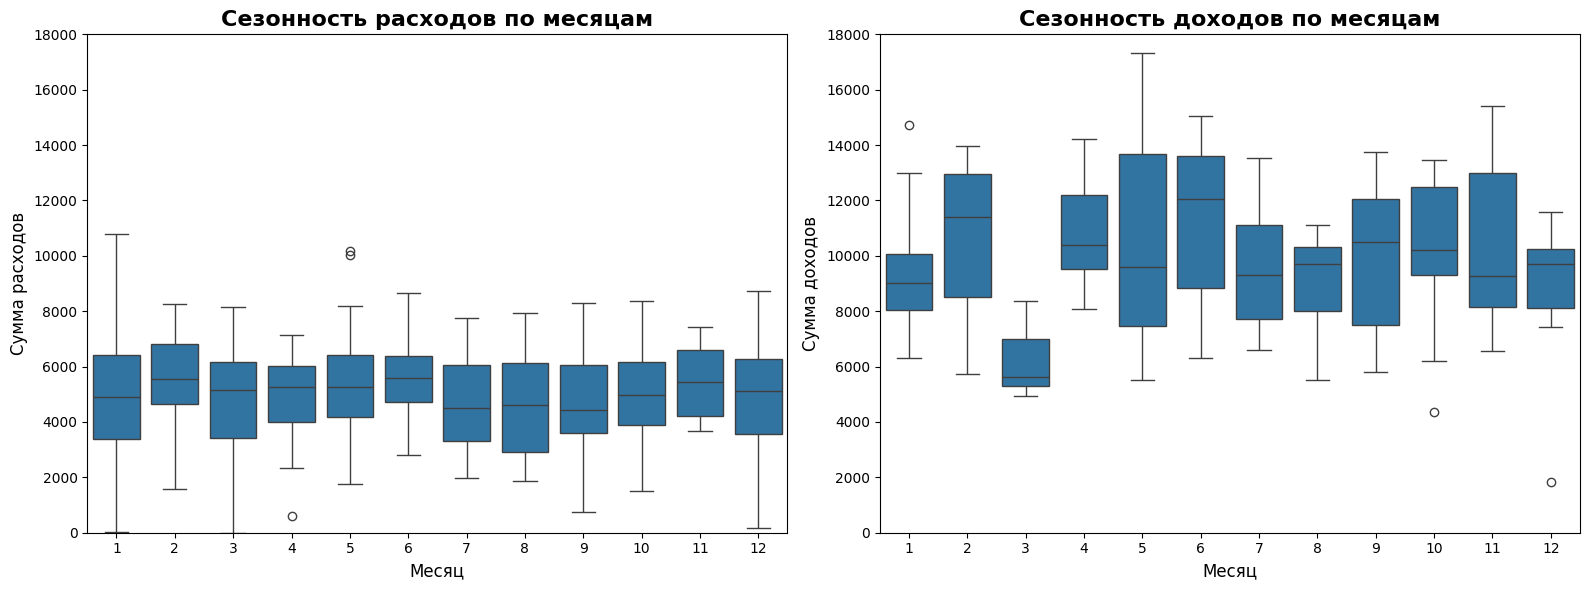

In [34]:
# Подготовка данных для анализа сезонности
expense_df = df[df['transaction_type'] == 'expense'].copy()
income_df = df[df['transaction_type'] == 'income'].copy()

# Извлекаем месяц для анализа сезонности
expense_df['month'] = pd.to_datetime(expense_df['date']).dt.month
income_df['month'] = pd.to_datetime(income_df['date']).dt.month

# 1. Визуальный анализ: боксплоты по месяцам
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Расходы по месяцам
sns.boxplot(x='month', y='amount', data=expense_df, ax=axes[0])
axes[0].set_title('Сезонность расходов по месяцам', fontsize=16, fontweight=700)
axes[0].set_xlabel('Месяц', fontsize=12, fontweight=300)
axes[0].set_ylabel('Сумма расходов', fontsize=12, fontweight=300)
axes[0].set_ylim(0, 18000)

# Доходы по месяцам
sns.boxplot(x='month', y='amount', data=income_df, ax=axes[1])
axes[1].set_title('Сезонность доходов по месяцам', fontsize=16, fontweight=700)
axes[1].set_xlabel('Месяц', fontsize=12, fontweight=300)
axes[1].set_ylabel('Сумма доходов', fontsize=12, fontweight=300)
axes[1].set_ylim(0, 18000)

plt.tight_layout()
plt.show()

Исходя из боксплотов, по объему сумм за месяца в расходах четкой сезонности не обнаруживается, следуя из нижнего и верхнего квантиля (50% центральных значений), которые +/- одинаковые из месяца в месяц в районах 3700 - 6500 руб. Стоит отметить, что, в целом, по значениям, наибольшая вариация по усам наблюдается в январе и декабре месяцах, где это, вероятно, может быть обусловлено праздничным подтекстом нового года. Однако это только гипотеза, требующая отдельной проработки. Другое дело наличие выбросов в апреле и в мае месяце, особенно в мае с несколькими транзакциями выше усов - это аномалии, которые требуют отдельного изучения

В категории доходов обнаруживается уже большая сезонность, так явно об этом можно сказать о марте месяце, где по всем показателям боксплот самый маленький. В среднем диапазон нижнего и верхнего квантилей суммы в районах 7500 - 14000, что куда больше расходов и свидетельствует о неком "нестабильном характере" получения денег. Это подтверждает и чуть большее количество выбросов - по одному в декабре, январе и октябре месяцах. Два из которых меньше усов - а значит ниже, чем статистически вообще могло предполагаться. И это тоже требует отдельного изучения

Вопрос 10.  Какие признаки чаще встречаются в фродовых транзакциях (is_fraudulent=True)?

transaction_type   expense    income  investment    refund  transfer
is_fraudulent                                                       
False             0.548450  0.246124    0.048450  0.063953  0.093023
True              0.918919  0.000000    0.081081  0.000000  0.000000

Топ категории для фродовых транзакций:
- expense: 91.89%
- investment: 8.11%
- income: 0.00%


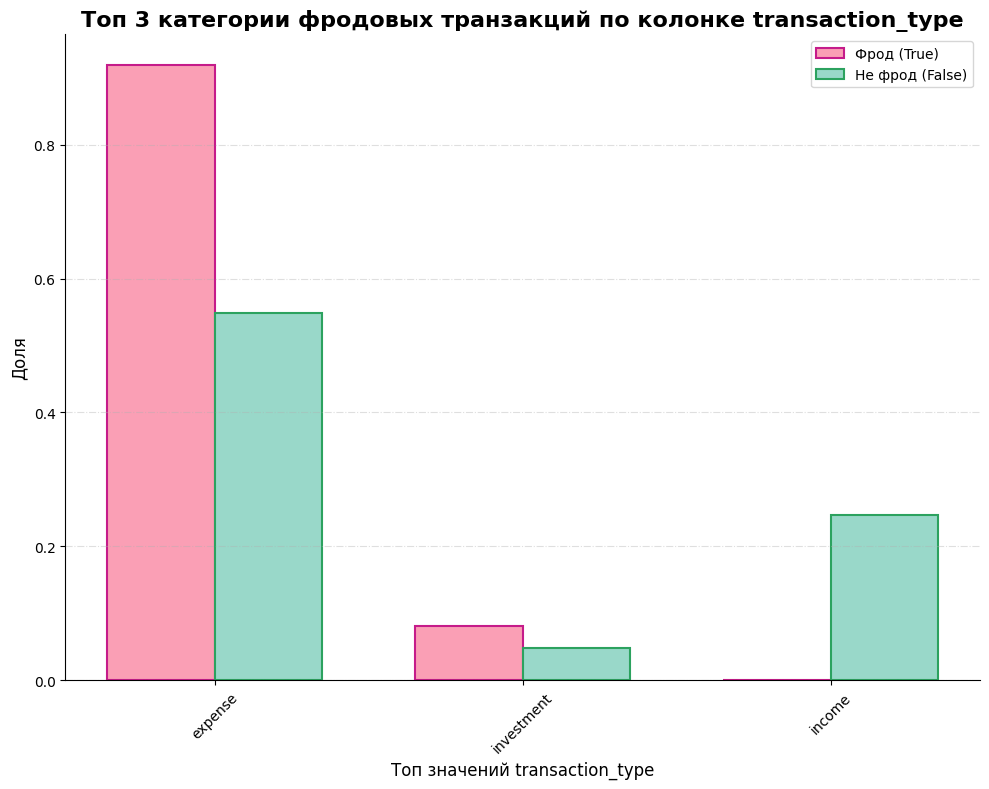

department      Finance        HR        IT  Marketing       R&D     Sales
is_fraudulent                                                             
False          0.141473  0.174419  0.135659   0.205426  0.149225  0.193798
True           0.162162  0.135135  0.162162   0.162162  0.081081  0.297297

Топ категории для фродовых транзакций:
- Sales: 29.73%
- Finance: 16.22%
- Marketing: 16.22%


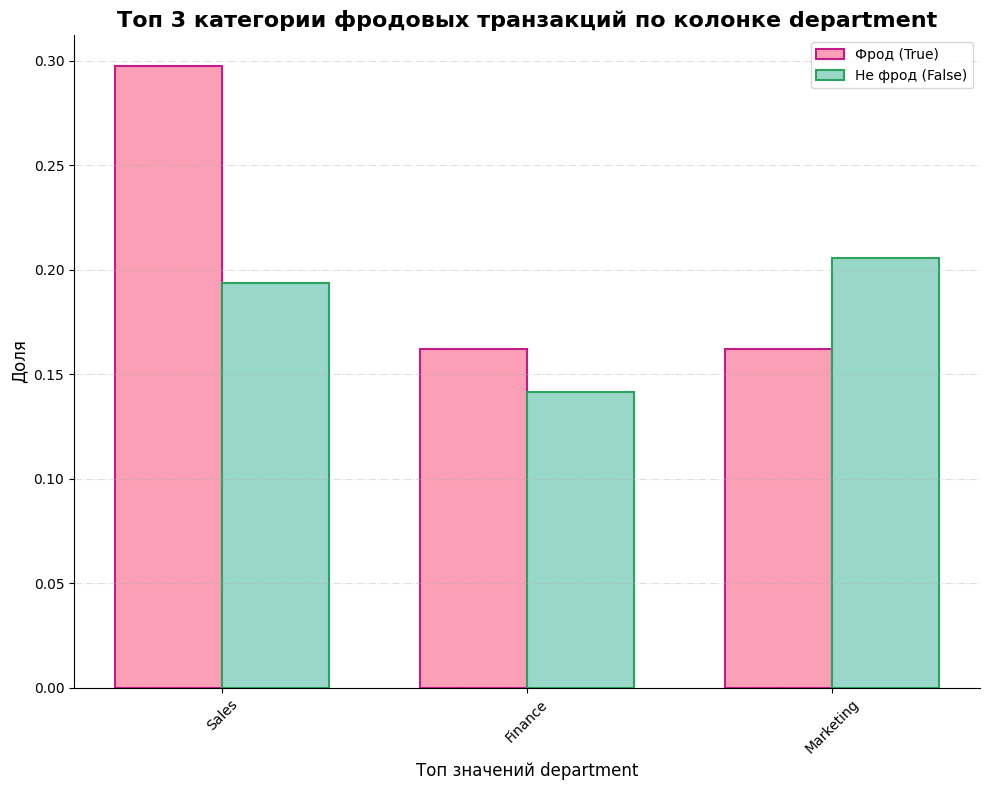

vendor         Alexander, Rogers and Glass  Boyd-Brown  \
is_fraudulent                                            
False                             0.021318    0.034884   
True                              0.000000    0.000000   

vendor         Bradley, Ortiz and Foster  Braun and Sons  \
is_fraudulent                                              
False                           0.027132        0.032946   
True                            0.027027        0.027027   

vendor         Campbell, Calderon and Reed  Chandler-Hicks  Cook and Sons  \
is_fraudulent                                                               
False                             0.025194        0.017442       0.021318   
True                              0.000000        0.054054       0.000000   

vendor         Dickson-Serrano  Duffy LLC  Fuentes, Chang and Mathis  ...  \
is_fraudulent                                                         ...   
False                 0.025194   0.031008                   0.0

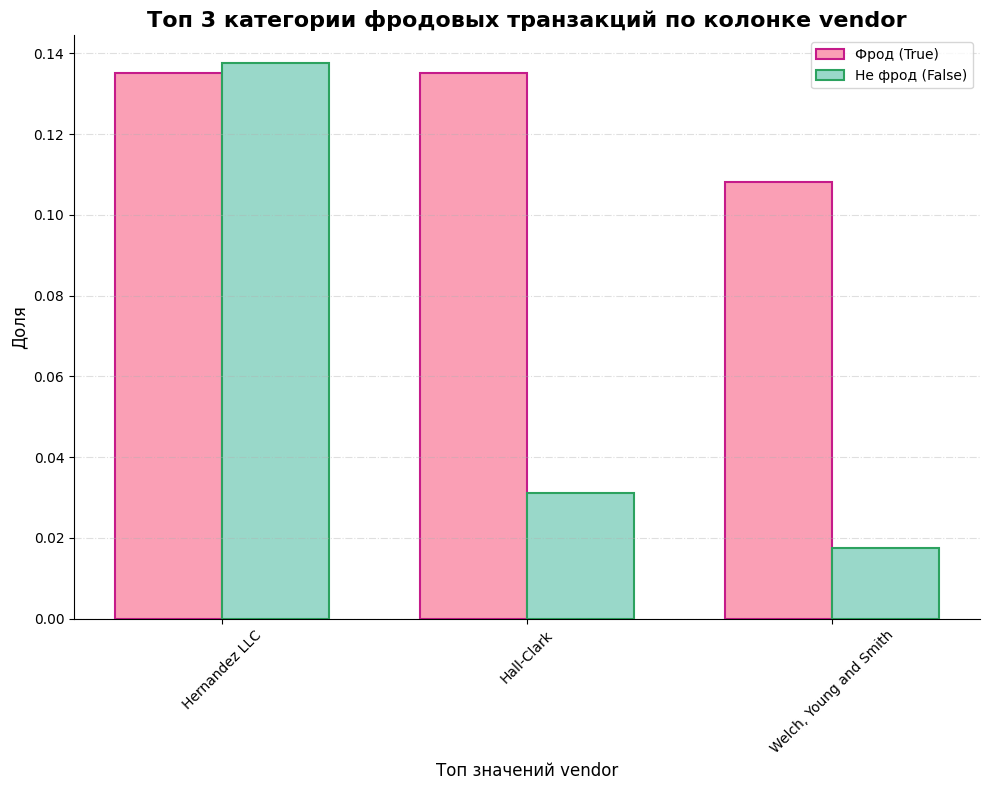

payment_method  bank_transfer      card      cash    crypto
is_fraudulent                                              
False                0.523256  0.325581  0.077519  0.073643
True                 0.000000  0.000000  0.675676  0.324324

Топ категории для фродовых транзакций:
- cash: 67.57%
- crypto: 32.43%
- card: 0.00%


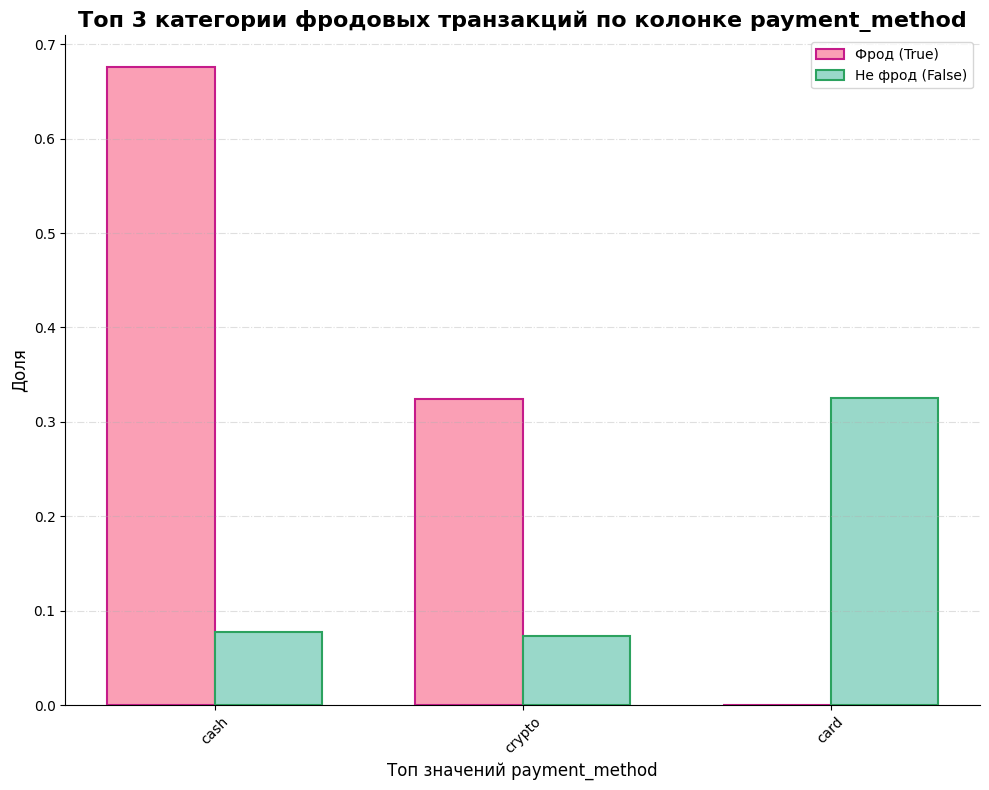

category       hardware  operational    salary  services  software     taxes  \
is_fraudulent                                                                  
False          0.133721     0.114341  0.129845  0.145349  0.120155  0.110465   
True           0.081081     0.027027  0.081081  0.162162  0.162162  0.135135   

category       training    travel  
is_fraudulent                      
False          0.106589  0.139535  
True           0.189189  0.162162  

Топ категории для фродовых транзакций:
- training: 18.92%
- services: 16.22%
- software: 16.22%


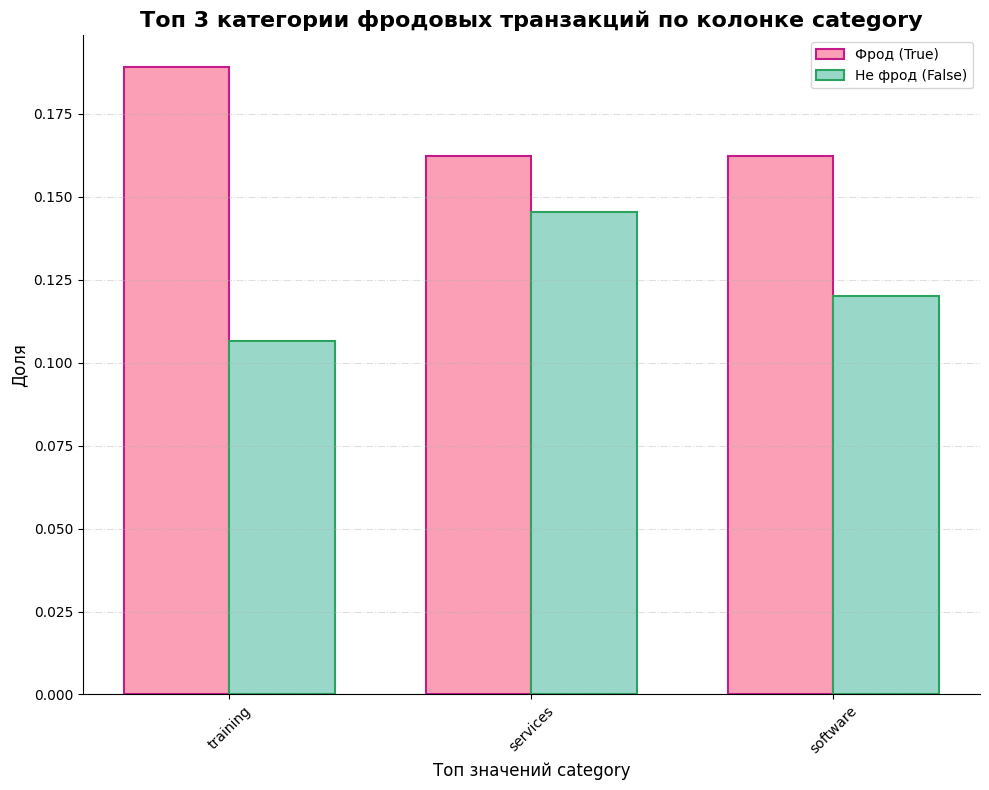

approved_by         CEO       CFO       COO       CTO  HR_Manager
is_fraudulent                                                    
False          0.228682  0.186047  0.178295  0.213178    0.193798
True           0.162162  0.324324  0.135135  0.189189    0.189189

Топ категории для фродовых транзакций:
- CFO: 32.43%
- HR_Manager: 18.92%
- CTO: 18.92%


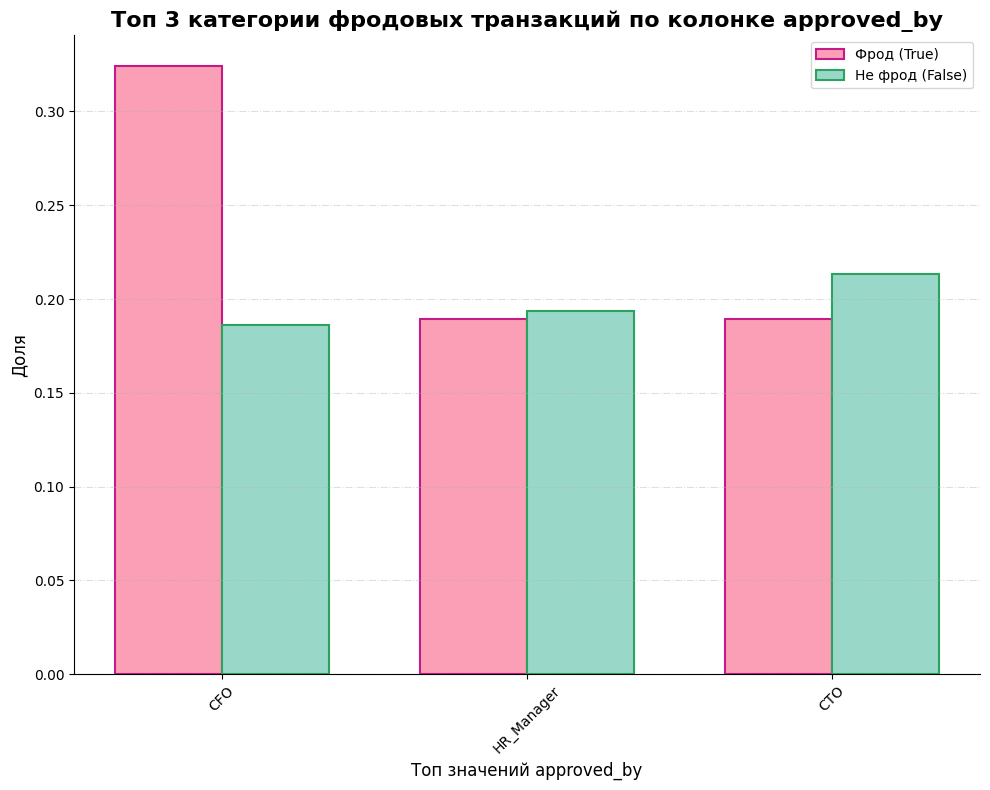

recurring         False     True 
is_fraudulent                    
False          0.736434  0.263566
True           0.783784  0.216216

Топ категории для фродовых транзакций:
- False: 78.38%
- True: 21.62%


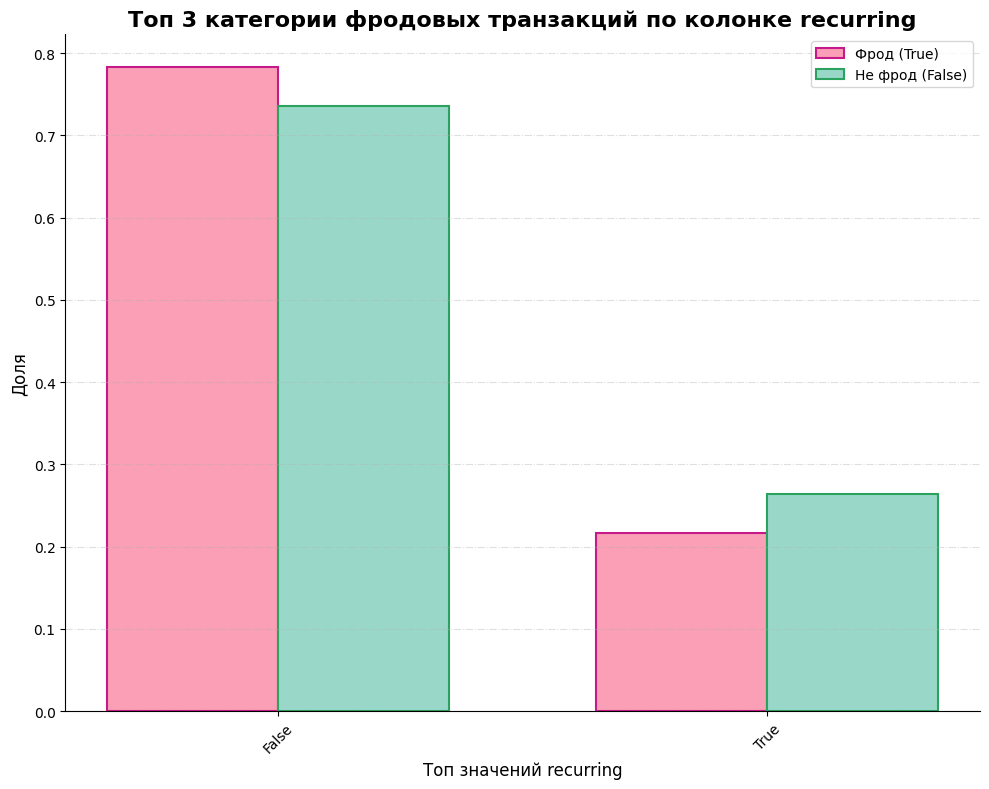

project_code    PRJ_001   PRJ_002  PRJ_003   PRJ_004  PRJ_005   PRJ_006  \
is_fraudulent                                                             
False          0.040698  0.046512  0.04845  0.048450  0.03876  0.044574   
True           0.054054  0.081081  0.00000  0.081081  0.00000  0.108108   

project_code    PRJ_007  PRJ_008   PRJ_009   PRJ_010   PRJ_011   PRJ_012  \
is_fraudulent                                                              
False          0.062016  0.03876  0.036822  0.046512  0.062016  0.067829   
True           0.027027  0.00000  0.027027  0.081081  0.108108  0.000000   

project_code    PRJ_013   PRJ_014   PRJ_015   PRJ_016   PRJ_017   PRJ_018  \
is_fraudulent                                                               
False          0.060078  0.056202  0.050388  0.050388  0.038760  0.050388   
True           0.081081  0.108108  0.054054  0.054054  0.027027  0.054054   

project_code    PRJ_019  PRJ_020  
is_fraudulent                     
False          

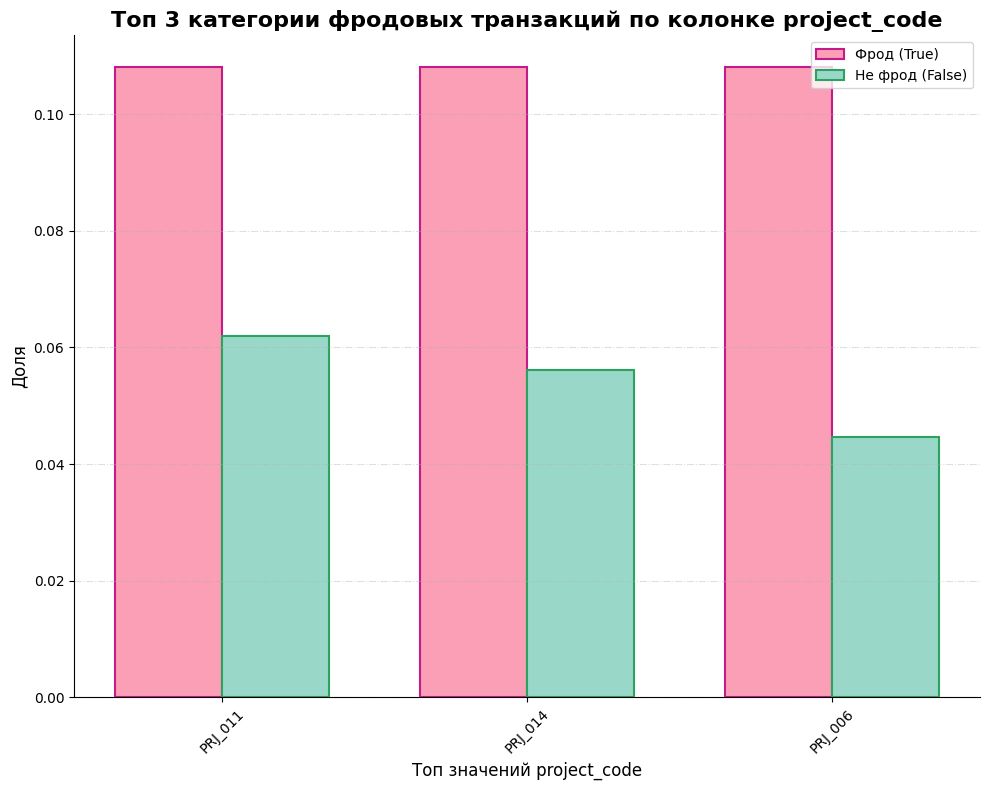

amount         3.29      30.06     33.77     80.95     86.37     96.74     \
is_fraudulent                                                               
False          0.001938  0.001938  0.001938  0.001938  0.001938  0.001938   
True           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

amount         130.52    147.38    167.10    171.57    ...  17324.51  \
is_fraudulent                                          ...             
False          0.001938  0.001938  0.001938  0.001938  ...  0.001938   
True           0.000000  0.000000  0.000000  0.000000  ...  0.000000   

amount         17808.91  18381.21  18404.41  19456.09  20610.77  20937.33  \
is_fraudulent                                                               
False          0.001938  0.001938  0.001938  0.001938  0.001938  0.001938   
True           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

amount         22313.83  22540.94  23361.25  
is_fraudulent                                
F

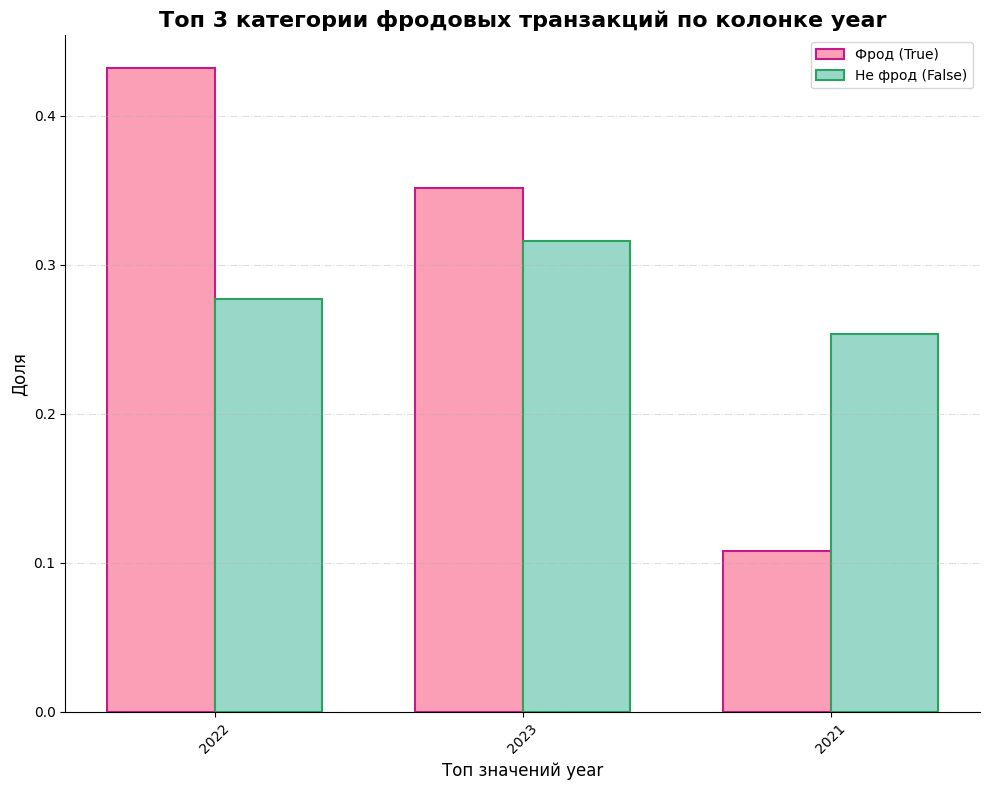

month                1         2         3         4         5         6   \
is_fraudulent                                                               
False          0.102713  0.102713  0.083333  0.106589  0.114341  0.063953   
True           0.108108  0.081081  0.081081  0.054054  0.135135  0.054054   

month                7         8         9         10        11        12  
is_fraudulent                                                              
False          0.077519  0.071705  0.058140  0.085271  0.058140  0.075581  
True           0.027027  0.108108  0.081081  0.054054  0.135135  0.081081  

Топ категории для фродовых транзакций:
- 11: 13.51%
- 5: 13.51%
- 1: 10.81%


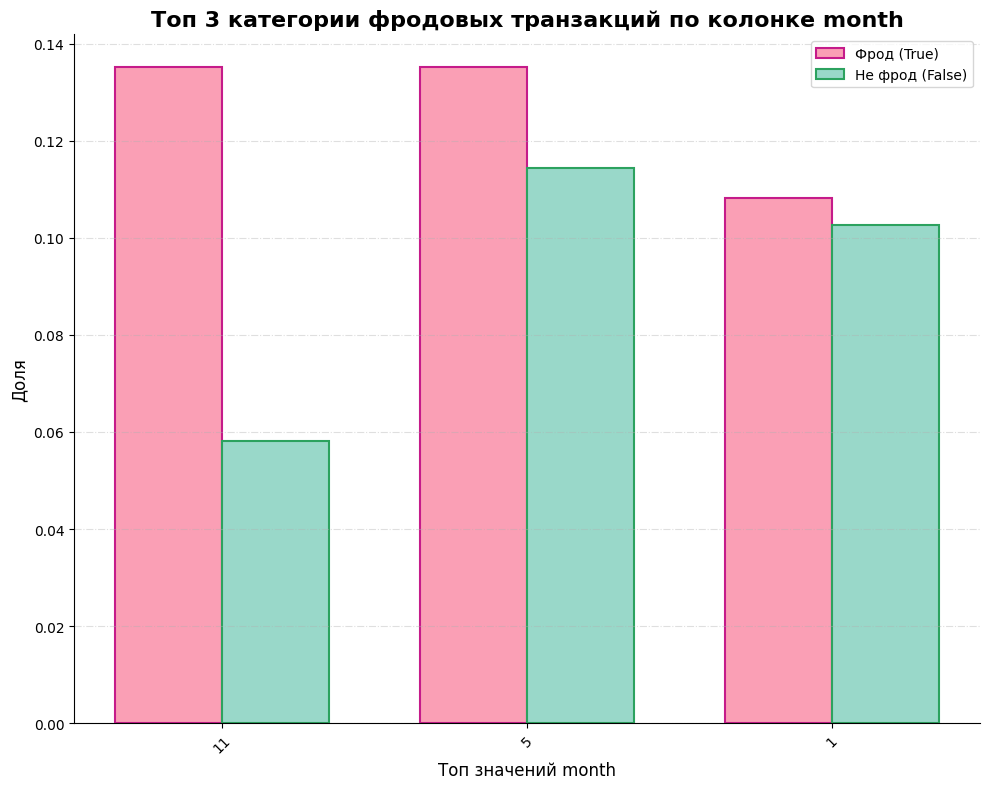

day                  1         2        3         4         5        6   \
is_fraudulent                                                             
False          0.038760  0.040698  0.03876  0.046512  0.042636  0.03876   
True           0.054054  0.027027  0.00000  0.027027  0.027027  0.00000   

day                  7         8         9         10  ...        22  \
is_fraudulent                                          ...             
False          0.023256  0.019380  0.040698  0.036822  ...  0.032946   
True           0.000000  0.027027  0.000000  0.000000  ...  0.027027   

day                  23        24        25        26        27        28  \
is_fraudulent                                                               
False          0.032946  0.025194  0.015504  0.029070  0.029070  0.036822   
True           0.000000  0.000000  0.027027  0.027027  0.054054  0.000000   

day                  29        30        31  
is_fraudulent                                
False    

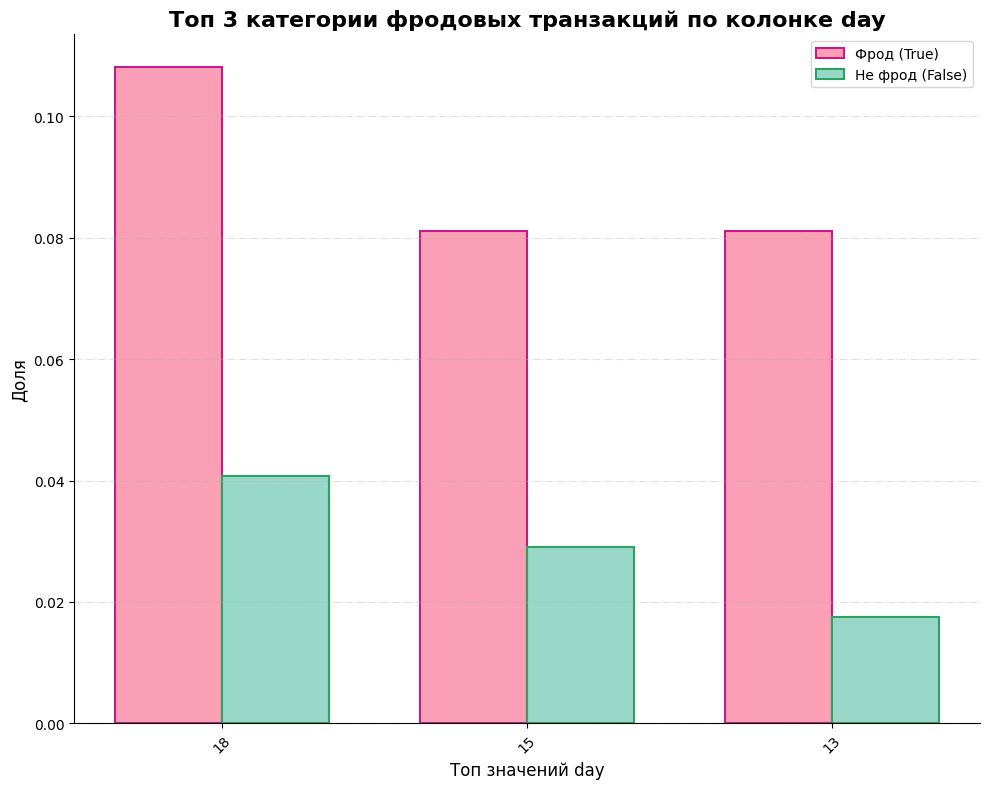

yearmonth       2021-01   2021-02   2021-03   2021-04   2021-05   2021-06  \
is_fraudulent                                                               
False          0.023256  0.025194  0.011628  0.023256  0.023256  0.027132   
True           0.027027  0.000000  0.000000  0.027027  0.000000  0.027027   

yearmonth       2021-07   2021-08   2021-09   2021-10  ...   2023-08  \
is_fraudulent                                          ...             
False          0.027132  0.021318  0.023256  0.017442  ...  0.040698   
True           0.000000  0.000000  0.000000  0.027027  ...  0.027027   

yearmonth       2023-09   2023-10   2023-11   2023-12   2024-01   2024-02  \
is_fraudulent                                                               
False          0.015504  0.040698  0.021318  0.031008  0.031008  0.032946   
True           0.000000  0.000000  0.081081  0.054054  0.000000  0.054054   

yearmonth       2024-03  2024-04   2024-05  
is_fraudulent                               
Fal

In [35]:
for col in df.columns:
  if col not in ['is_fraudulent', 'date']:
    col_fraudulent_cross = pd.crosstab(index=df['is_fraudulent'], columns=df[col], normalize='index')
    print(col_fraudulent_cross)

    if col_fraudulent_cross.shape[1] < 35 and True in col_fraudulent_cross.index:
        print("\nТоп категории для фродовых транзакций:")
        top_fraud_categories = col_fraudulent_cross.loc[True].sort_values(ascending=False).head(3)
        for category, value in top_fraud_categories.items():
            print(f"- {category}: {value:.2%}")

        plt.figure(figsize=(10, 8))

        categories = top_fraud_categories.index
        fraud_values = []
        non_fraud_values = []

        for cat in categories:
            if False in col_fraudulent_cross.index and cat in col_fraudulent_cross.loc[False]:
                non_fraud_values.append(col_fraudulent_cross.loc[False, cat])
            else:
                non_fraud_values.append(0)
            fraud_values.append(col_fraudulent_cross.loc[True, cat])

        x = np.arange(len(categories))
        width=0.35
        plt.bar(x - width/2, fraud_values, width, color='#fa9fb5', edgecolor='#c51b8a', linewidth=1.5, label='Фрод (True)')
        plt.bar(x + width/2, non_fraud_values, width, color='#99d8c9', edgecolor='#2ca25f', linewidth=1.5, label='Не фрод (False)')
        ax = plt.gca()

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.grid(alpha=0.4, axis='y', linestyle='-.')

        plt.title(f'Топ 3 категории фродовых транзакций по колонке {col}', fontsize=16, fontweight=700)
        plt.xlabel(f'Топ значений {col}', fontsize=12, fontweight=300)
        plt.ylabel('Доля', fontsize=12, fontweight=300)
        plt.xticks(x, categories, rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

Среди мошеннических транзакций, больше 91% их составляют вид "транзакций-расходов". Около 1/3 из фрод-транзакций принадлежат отделу продаж. Интересно, что среди поставщиков по доле фрод-транзакций выделяются Barron Ltd (13,5%) и Williams, Rodriguez and Martin (10,1%) поскольку по соотношению фрод/нефрод транзакций большое превалирование идет в сторону фрода. Что касается методов оплаты - то все фрод-транзакции происходят либо через наличные, либо через крипту; вероятно из-за их признака непрозрачности. Больше 1/3 фрод-транзакций одабриваются CFO. Интересно, что некоторые проекты (PRJ_011, PRJ_014, PRJ_006) имеют долю в мошеннических транзакциях более чем в 2 раза выше. Из временных инсайтов - 2022 год составляет 28% обычных транзакций, но 43% мошеннических. Ноябрь (месяц 11) составляет только 6% обычных, но 14% мошеннических транзакций.

Полученные сведения дают понять, что в компании не все так радушно и она скрывает в себе проблемы, которые могут грозить ей в долгосрочной (а то и в краткосрочной) перспективе - убытком и даже закрытием по юридическим причинам

Вопрос 11. Какое распределение сумм у фродовых vs. нормальных транзакций?

Количество фрод транзакций = 37, в то время как не фрод = 516 
доля фрод транзакций в генеральной выборке = 6.69%
p-value Манна-Уитни = 0.1195
p-value теста Муда на медианы = 1.0000


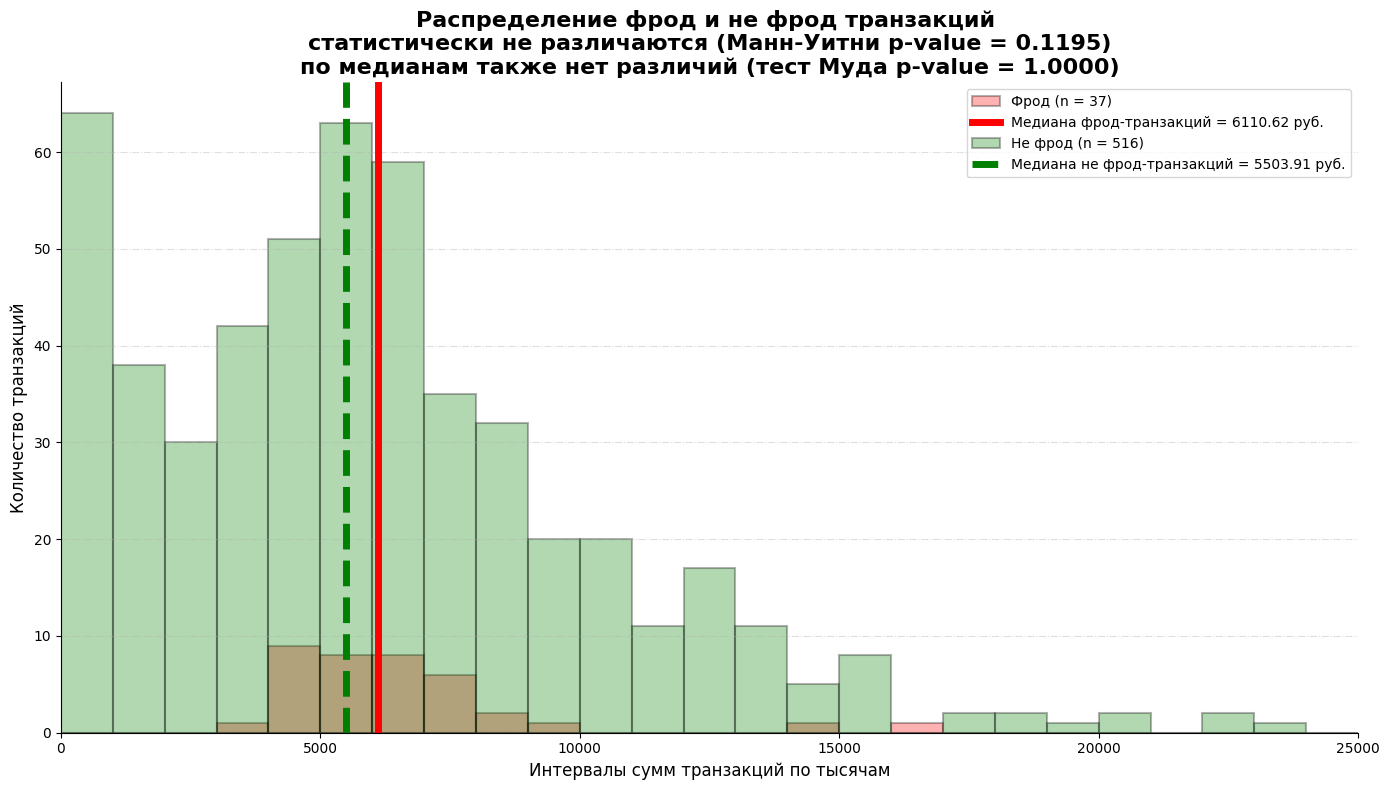

In [36]:
fraud_amount = df.loc[df['is_fraudulent'] == True, 'amount']
non_fraud_amount = df.loc[df['is_fraudulent'] == False, 'amount']
fraud_amount_median = np.median(fraud_amount)
non_fraud_amount_median = np.median(non_fraud_amount)

count_fraud = len(fraud_amount)
count_non_fraud = len(non_fraud_amount)
fraction_fraud = count_fraud/(count_fraud + count_non_fraud) * 100
print(f'Количество фрод транзакций = {count_fraud}, в то время как не фрод = {count_non_fraud} \n'
f'доля фрод транзакций в генеральной выборке = {fraction_fraud:.2f}%')

statistic, p_value_whitneyu = stats.mannwhitneyu(fraud_amount, non_fraud_amount, alternative='two-sided')
print(f'p-value Манна-Уитни = {p_value_whitneyu:.4f}')

less_fraud = sum(x < fraud_amount_median for x in fraud_amount)
greater_fraud = sum(x >= fraud_amount_median for x in fraud_amount)

less_non_fraud = sum(x < non_fraud_amount_median for x in non_fraud_amount)
greater_non_fraud = sum(x >= non_fraud_amount_median for x in non_fraud_amount)

contingency_table = [[less_fraud, greater_fraud],
                     [less_non_fraud, greater_non_fraud]]

chi2, p_value_median, _, _ = stats.chi2_contingency(contingency_table)
print(f'p-value теста Муда на медианы = {p_value_median:.4f}')

bins = np.linspace(0, 25000, 26)

fig, axes = plt.subplots(figsize=(14, 8))

plt.hist(x=fraud_amount, bins=bins, label=f'Фрод (n = {count_fraud})', color='red',
         linewidth=1.5, edgecolor='black', alpha=0.3)
plt.axvline(fraud_amount_median, color='red', linewidth=5,
            label=f'Медиана фрод-транзакций = {fraud_amount_median:.2f} руб.')

plt.hist(x=non_fraud_amount, bins=bins, label=f'Не фрод (n = {count_non_fraud})', color='green',
         linewidth=1.5, edgecolor='black', alpha=0.3)
plt.axvline(non_fraud_amount_median, color='green', linewidth=5, linestyle='--',
            label=f'Медиана не фрод-транзакций = {non_fraud_amount_median:.2f} руб.')

plt.title(f'Распределение фрод и не фрод транзакций \n'
f'статистически не различаются (Манн-Уитни p-value = {p_value_whitneyu:.4f})\n'
f'по медианам также нет различий (тест Муда p-value = {p_value_median:.4f})', fontsize=16, fontweight=700)
plt.ylabel('Количество транзакций', fontsize=12, fontweight=300)
plt.xlabel('Интервалы сумм транзакций по тысячам', fontsize=12, fontweight=300)
plt.xlim(0, 25000)

axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.grid(alpha=0.4, axis='y', linestyle='-.')

plt.legend()
plt.tight_layout()
plt.show()

In [37]:
def bootstrap_ci(data, func=np.median, n_iterations=1000, ci=95):
    stats = []
    for _ in range(n_iterations):
        sample = resample(data, replace=True, n_samples=len(data))
        stat = func(sample)
        stats.append(stat)
    lower = np.percentile(stats, (100 - ci) / 2)
    upper = np.percentile(stats, 100 - (100 - ci) / 2)
    return lower, upper, stats

fraud_ci_lower, fraud_ci_upper, fraud_stats = bootstrap_ci(fraud_amount)
nonfraud_ci_lower, nonfraud_ci_upper, nonfraud_stats = bootstrap_ci(non_fraud_amount)

print(f"Фрод медиана 95% CI: [{fraud_ci_lower:.2f}, {fraud_ci_upper:.2f}]")
print(f"Не фрод медиана 95% CI: [{nonfraud_ci_lower:.2f}, {nonfraud_ci_upper:.2f}]")


Фрод медиана 95% CI: [5286.23, 6856.29]
Не фрод медиана 95% CI: [5214.65, 5754.68]


Несмотря на то, что фрод-транзакций у нас 37, а не фрод 516 (разница в 13,5 раза) - по медианам наблюдается, что фрод-транзакции, в среднеем происходят на большую сумму, чем не фрод транзакции (разница на 606 рублей), несмотря на их меньшее количество.

Тем не менее медианы статистически абсолютно не значимы по различию. Это показал тест Муда на медианы с p-value = 1.000. Что касается самих распределений, то независимо от противоположных размеров видов транзакций - между распределениями также нет статистически значимой разницы (p-value Манна-Уитни = 0.1195). Они оба имеют ненормальное распределение с длинным хвостом в правой стороне.

Вопрос 12. Какие поставщики (vendor) чаще фигурируют во фродовых операциях?

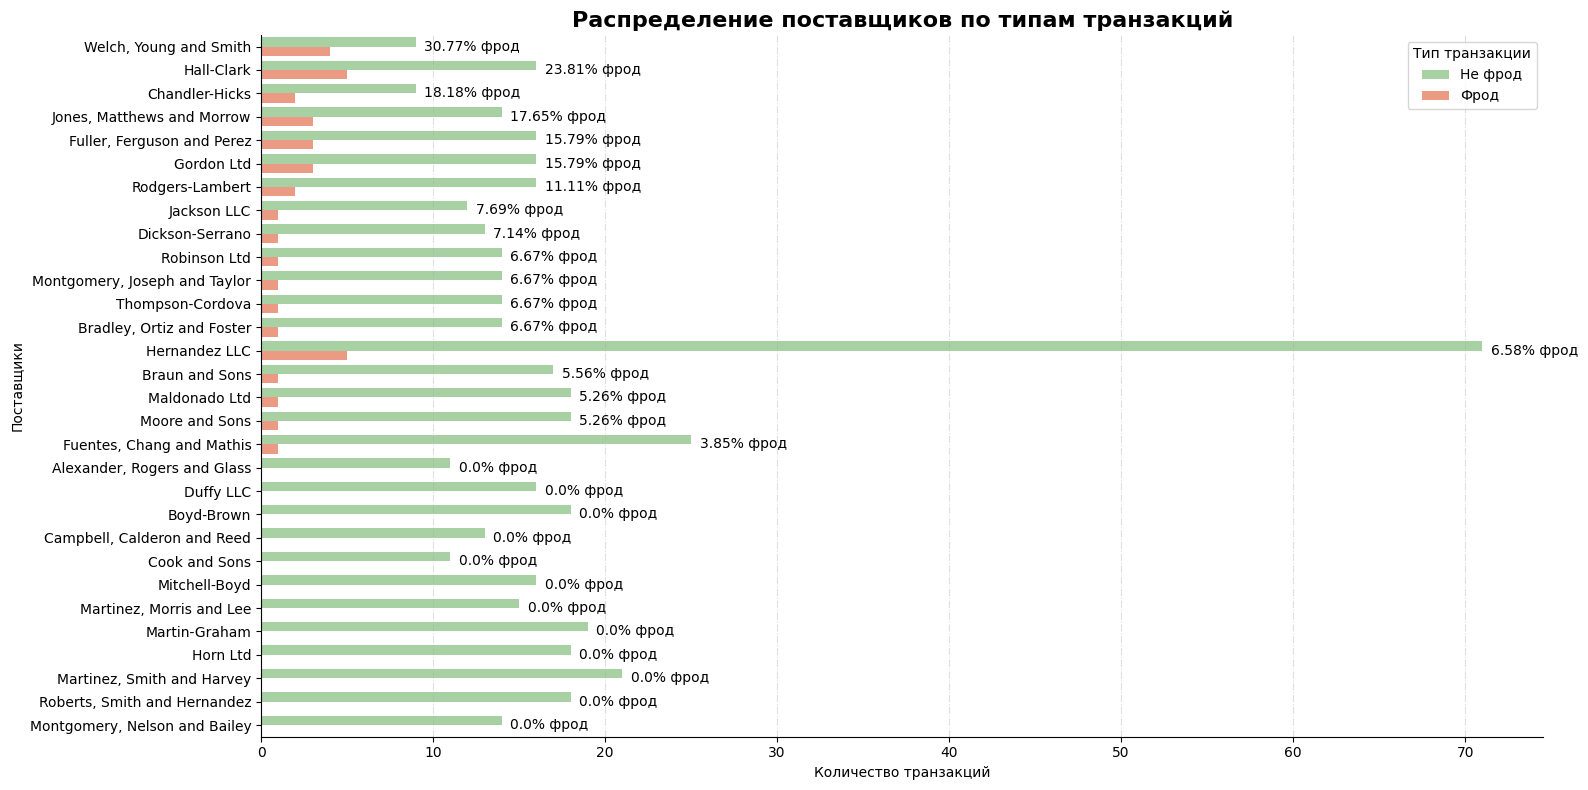

In [38]:
fig, axes = plt.subplots(figsize=(16, 8))

vendor_fraud_counts = df.groupby(['vendor', 'is_fraudulent']).size().reset_index(name='count')
vendor_totals = vendor_fraud_counts.groupby('vendor')['count'].sum().reset_index()
vendor_fraud = vendor_fraud_counts[vendor_fraud_counts['is_fraudulent'] == True].copy()
vendor_fraud = vendor_fraud.rename(columns={'count': 'fraud_count'})
vendor_stats = vendor_totals.merge(vendor_fraud[['vendor', 'fraud_count']], on='vendor', how='left')
vendor_stats['fraud_count'] = vendor_stats['fraud_count'].fillna(0)
vendor_stats['fraud_percentage'] = (vendor_stats['fraud_count'] / vendor_stats['count'] * 100).round(2)
sorted_vendors = vendor_stats.sort_values('fraud_percentage', ascending=False)['vendor'].tolist()

vendor_fraud_counts['vendor'] = pd.Categorical(
    vendor_fraud_counts['vendor'],
    categories=sorted_vendors,
    ordered=True
)

axes = sns.barplot(y='vendor', x='count', hue='is_fraudulent', data=vendor_fraud_counts,
           palette={True: '#fc9272', False: '#a1d99b'}, orient='h')

for i, row in vendor_stats.iterrows():
    vendor_index = sorted_vendors.index(row['vendor'])
    axes.text(row['count'] - row['fraud_count'] + 0.5, vendor_index, f"{row['fraud_percentage']}% фрод",
            va='center')


plt.title('Распределение поставщиков по типам транзакций', fontsize=16, fontweight=700)
plt.ylabel('Поставщики')
plt.xlabel('Количество транзакций')

axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.grid(alpha=0.4, axis='x', linestyle='-.')

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Не фрод', 'Фрод'], title='Тип транзакции')

plt.tight_layout()
plt.show()

Чаще всего фрод-транзакциями (от 10%, поскольку считаю, что когда каждая 10 транзакция минимум с поставщиком является фродом - это повод к обеспокоенности, а не ошибки или единоразового халатного отношения ) промышляют взаимоотношения с вышеперечисленными игроками.

Данный список является полем понимания - какие фирмы могут существовтаь только на бумаге, являясь фиктивными с целью фрод-заработка.

Вопрос 13. Есть ли связь между фродом и регулярностью (recurring)?

In [39]:
correlate_df = df[['recurring', 'is_fraudulent']].copy()
for col in correlate_df.columns:
  correlate_df[col] = correlate_df[col].astype(int)
corr_crosstab = pd.crosstab(index=correlate_df['is_fraudulent'], columns=correlate_df['recurring'], normalize=True)
corr_crosstab

recurring,0,1
is_fraudulent,,
0,0.687161,0.245931
1,0.052441,0.014467


Шансы мошенничества для регулярных транзакций на 22.92% ниже, чем для нерегулярных транзакций


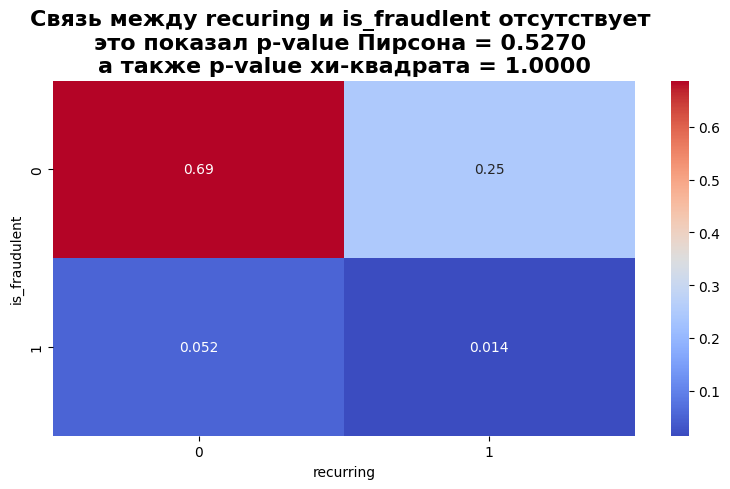

In [40]:
odds_ratio = (corr_crosstab[1][1]/corr_crosstab[1][0])/(corr_crosstab[0][1]/corr_crosstab[0][0])
print(f'Шансы мошенничества для регулярных транзакций на {(1- odds_ratio) * 100:.2f}% ниже, чем для нерегулярных транзакций')

chi2, p_chi2, _, _ = stats.chi2_contingency(contingency_table)
pears_recur_frod = stats.pearsonr(correlate_df['recurring'], correlate_df['is_fraudulent'])

plt.figure(figsize=(8, 5))
sns.heatmap(corr_crosstab, annot=True, fmt='.2g', cmap='coolwarm')
plt.title('Связь между recuring и is_fraudlent отсутствует \n'
f'это показал p-value Пирсона = {pears_recur_frod[1]:.4f} \n'
f'а также p-value хи-квадрата = {p_chi2:.4f}', fontsize=16, fontweight=700)
plt.tight_layout()
plt.show()

Связи между такими переменными как "регулярность" и "мошенническая ли транзакция" статистически не обнаружено. Это подтверждается как коэффициентом корреляции Пирсона, так и более подходящим для категориальных переменных тестом хи-квадрат, который показал p-value = 1. Расчет отношения шансов (odds ratio) показывает, что шансы мошенничества для регулярных транзакций составляют 77,08% от шансов для нерегулярных транзакций, или, другими словами, шансы мошенничества для регулярных транзакций на 22,92% ниже, чем для нерегулярных, хотя эта разница статистически незначима.

Вопрос 14. Есть ли департаменты, которые чаще попадают в фрод?

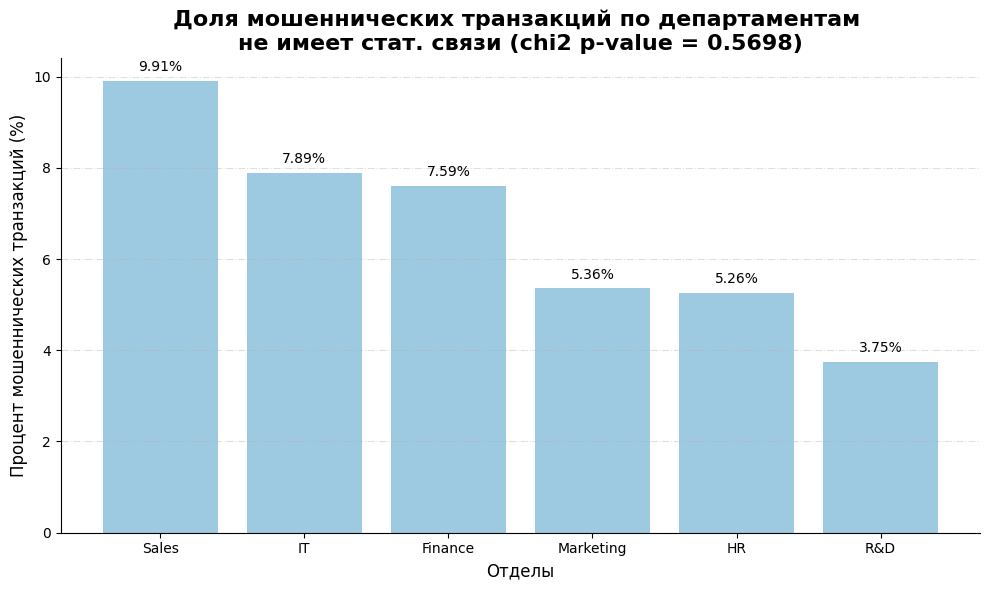

In [41]:
dept_fraud = df.groupby('department')['is_fraudulent'].agg(['mean', 'count'])
dept_fraud.columns = ['Доля мошенничества', 'Количество транзакций']
dept_fraud['Доля мошенничества'] = dept_fraud['Доля мошенничества'] * 100

contingency_table = pd.crosstab(df['department'], df['is_fraudulent'])
chi2, chi2_p, _, _ = stats.chi2_contingency(contingency_table)

dept_fraud = dept_fraud.sort_values('Доля мошенничества', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(dept_fraud.index, dept_fraud['Доля мошенничества'], color='#9ecae1')

for bar in bars:
    height = bar.get_height()
    offset = max(dept_fraud['Доля мошенничества']) * 0.015
    ax.text(bar.get_x() + bar.get_width()/2., height + offset,
            f'{height:.2f}%', ha='center', va='bottom')

plt.title('Доля мошеннических транзакций по департаментам \n'
f'не имеет стат. связи (chi2 p-value = {chi2_p:.4f})', fontsize=16, fontweight=700)
plt.ylabel('Процент мошеннических транзакций (%)', fontsize=12, fontweight=300)
plt.xlabel('Отделы', fontsize=12, fontweight=300)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(alpha=0.4, axis='y', linestyle='-.')
plt.tight_layout()
plt.show()

Относительно остальных, топ-3 отдела по мошенническим транзакциям представляют собой Finance (7,59$), IT (7,89%) и Sales (9,91%). Причем стоит заметить, что в отделе Sales исходя из 9,91% почти каждая 10-я транзакциям имеет признак фрода. Тем не менее стат. связи на основании хи-квадрата не обнаружено (p-value = 0.5698) чтобы мы могли явно об этом говорить

15. Какие наиважные признаки у фродовых и нормальных транзакций?

Рассмотрим, какие признаки наиважные в датасете с точки зрения ML (RandomForestClassifier)

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['transaction_type', 'department', 'payment_method', 'category',
                    'approved_by', 'recurring', 'project_code']

numerical_cols = ['amount']

df_ml = df.copy()
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = encoder.fit_transform(df_ml[categorical_cols])
encoded_df = pd.DataFrame(
    encoded_cats,
    columns=encoder.get_feature_names_out(categorical_cols)
)

X = pd.concat([df_ml[numerical_cols].reset_index(drop=True), encoded_df], axis=1)
y = df_ml['is_fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

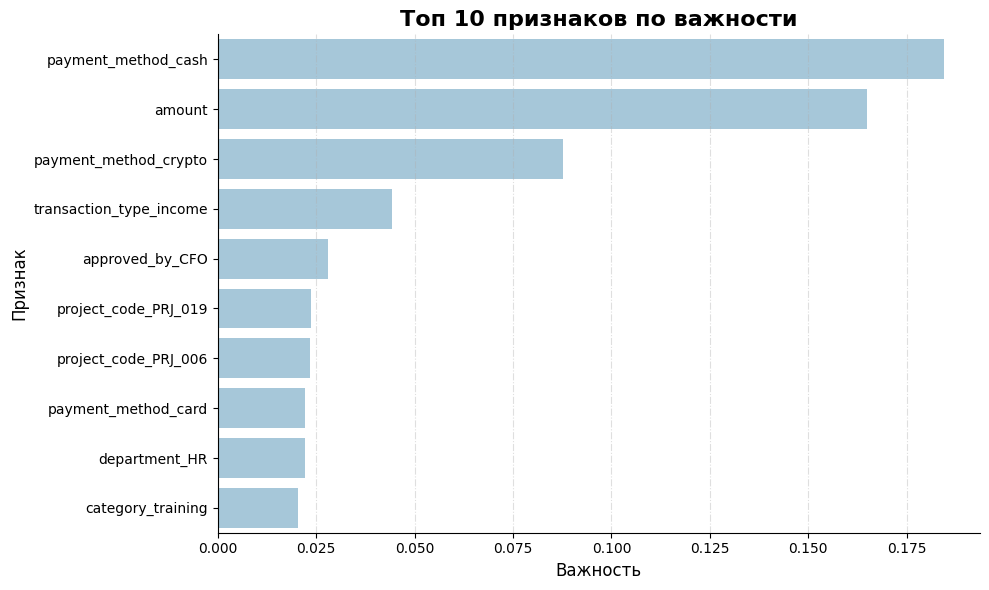

                    Feature  Importance
11      payment_method_cash    0.184386
0                    amount    0.165019
12    payment_method_crypto    0.087781
1   transaction_type_income    0.044170
20          approved_by_CFO    0.028060
42     project_code_PRJ_019    0.023582
29     project_code_PRJ_006    0.023450
10      payment_method_card    0.022245
5             department_HR    0.022091
18        category_training    0.020305


In [46]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

fig, axes = plt.subplots(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), color='#9ecae1')
plt.title('Топ 10 признаков по важности', fontsize=16, fontweight=700)

plt.xlabel('Важность', fontsize=12, fontweight=300)
plt.ylabel('Признак', fontsize=12, fontweight=300)

axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.grid(alpha=0.4, axis='x', linestyle='-.')
plt.tight_layout()
plt.show()

print(feature_importance.head(10))

Исходя из этого маленького применения ML - наиболее важные признаки понимания фрод и не фрод транзакций служат - оплата наличными, объем транзакции, оплата криптой, оплата картой и транзакция доходом. В целом, это логично из того анализа, что мы проводили ранее

1. Фрод-транзакции куда больше, чем нормальных, происходят за счет cash или наличных. Вероятно это связано с меньшей прозрачностью анализа опдобных операций. Это неудивительный признак, но то что он имеет 18% важности определенно говорит о его серьезном вкладе в понимание различий между фрод и не фрод транзакциями
2. Несмотря на меньшее количество фрод транзакий, их суммы, их среднее значение по медиане примерно равна медиане нормальных транзакций. И тем не менее, несмотря на отсутствие статистической связи, медиана фрод-сумм чуть выше нормальных на 600 рублей.
3. Оплата по крипте - третий наиболее важный признак именно оплата по крипте. Это также неудивительный признак, поскольку фрод-транзакции осуществляются либо наличкой, либо криптой. Третьего не дано. И это явный красный флаг

Таким образом, был проведен EDA и чуть-чуть ML-анализ синтетического финансового датасета.

На основании проведенного анализа мы можем сказать, что больше половины транзакций в организации приходится на расходы (57%). И несмотря на то, что пока доходы превалируют над расходами (по Манн-Кендаллу, смотреть вопрос 8) на 1,84 руб. - это ничтожно малый размер, который если не идет в убыток - то сильно сковывает мобильность организации. Необходимо наращивать финансовый запас во избежание возможных проблем.
Для этого следует минимизировать сезонность которая имеется достаточно широкая у доходов, но слабо представлена у расходов. Даже небольшая минимизация поможет лучше планировать, избегать неопределенностей и, соответтсвенно, меньше тратить деньги.

Одной из насущных проблем, которая может быть причиной малого баланса между доходами и расходами - это фрод-транзакции, которые в большинстве своем (примерно 90%) приходятся на расходы организации. Учитывая вопрос 10, около 30% транзакций приходятся на отдел продаж и около 15% на finance, а вот по категориям топ 3 стал training, services или software. Эти данные могут свидетельствовать о шарлатанстве со стороны лже-коучей, специально подосланных для фрод-транзакций, возможно "темных программ" либо темных улсгах со стороны для облегчения жизни, халатно использованных кем-то назло остальным. Однако четко сказать что "вот так-то так-то" - это фрод транзакция явно нельзя по этим признакам - потому что нормальные транзакции это также имеют.

Благодаря ML мы знаем основные признаки в роде способа оплаты наличкой, крипты и объема суммы. К этому стоит прислушаться, но все равно не лететь сломя голову и оценить комплексно. Например, зная вышеперечисленные факты и видя, что транзакция идет с контрагентом с 30,77% фрод-транзакциями до этого или это операция была принята CFO, который также имеет чуть выше 30% транзакций типа фрод - это +1 очко к подозрительности операций. Достигнутов 3 очка подозрительности? Классифицируем как фрод и отклоняем. Так мы можем минимизировать это явление

В общем говоря - это комплексная проблема и решение ее должно быть постепенно шаг за шагом, чтобы бизнес не рухнул, а наоборот окреп и стал сильнее